<a href="https://colab.research.google.com/github/arijit780/S-Transform_in_fault_diagnosis/blob/main/updated03_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy,lognorm
from scipy.signal import hilbert, periodogram, butter, sosfilt, spectrogram
from scipy import signal

!unzip "/content/drive/MyDrive/nasaT2-20230816T171611Z-001.zip" -d "/content/IMS-3"

#!ls /content/
# path = '/kaggle/input/bearing-dataset/2nd_test/2nd_test/2004.02.12.10.32.39'


Archive:  /content/drive/MyDrive/nasaT2-20230816T171611Z-001.zip
replace /content/IMS-3/nasaT2/2004.02.19.05.02.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.02.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.06.22.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.32.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.01.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.06.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.01.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.22.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.00.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.42.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.32.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.04.42.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.02.42.txt  
  inflating: /content/IMS-3/nas

In [ ]:
path = '/content/IMS-3/nasaT2'  # Adjust based on your actual path

In [ ]:
 #Define functions to compute skewness and kurtosis
from scipy.stats import weibull_min, norm

def compute_skewness(data):
    return ((np.mean(data**3)) / (np.mean(data**2))**(3/2))

def compute_kurtosis(data):
    return ((np.mean(data**4)) / (np.mean(data**2))**2)
'''def weibull_log_likelihood(data):
    shape, loc, scale = weibull_min.fit(data, floc=0)
    pdf_values = weibull_min.pdf(data, shape, loc, scale)
    epsilon = 1e-10
    log_likelihood = np.sum(np.log(pdf_values + epsilon))
    return -log_likelihood

def gaussian_log_likelihood(data):
    mu, std = np.mean(data), np.std(data)
    pdf_values = norm.pdf(data, mu, std)
    epsilon = 1e-10
    log_likelihood = np.sum(np.log(pdf_values + epsilon))
    return -log_likelihood'''
from scipy.stats import weibull_min, norm
import numpy as np

def weibull_log_likelihood(data):
    """
    Compute the negative log likelihood of a dataset under the assumption it follows a Weibull distribution.

    Parameters:
    data (array-like): Input data. Assumed to be drawn from a Weibull distribution.

    Returns:
    float: Negative log likelihood of the data under a Weibull distribution.
    """

    # Fit a Weibull distribution to the data. floc=0 fixes the location parameter at zero.
    # 'shape', 'loc', and 'scale' are the parameters of the fitted Weibull distribution.
    shape, loc, scale = weibull_min.fit(data, floc=0)

    # Calculate the probability density function (PDF) values of the data points
    # under the fitted Weibull distribution.
    pdf_values = weibull_min.pdf(data, shape, loc, scale)

    # Small constant to avoid taking log of zero (handles numerical stability issues)
    epsilon = 1e-10

    # Calculate the log likelihood of the data under the Weibull distribution.
    # Sum of log(PDF values) gives the log likelihood. Adding epsilon to avoid log(0).
    log_likelihood = np.sum(np.log(pdf_values + epsilon))

    # Return the negative log likelihood.
    return -log_likelihood

def gaussian_log_likelihood(data):
    """
    Compute the negative log likelihood of a dataset under the assumption it follows a Gaussian distribution.

    Parameters:
    data (array-like): Input data. Assumed to be drawn from a Gaussian distribution.

    Returns:
    float: Negative log likelihood of the data under a Gaussian distribution.
    """

    # Calculate the mean (mu) and standard deviation (std) of the data.
    mu, std = np.mean(data), np.std(data)

    # Calculate the probability density function (PDF) values of the data points
    # under a Gaussian distribution with the calculated mean and standard deviation.
    pdf_values = norm.pdf(data, mu, std)

    # Small constant to avoid taking log of zero (handles numerical stability issues)
    epsilon = 1e-10

    # Calculate the log likelihood of the data under the Gaussian distribution.
    # Sum of log(PDF values) gives the log likelihood. Adding epsilon to avoid log(0).
    log_likelihood = np.sum(np.log(pdf_values + epsilon))

    # Return the negative log likelihood.
    return -log_likelihood



def calculate_renyi_entropy(data, alpha):
    """
    Compute the Renyi entropy of a given data distribution.

    Parameters:
    data (array-like): Input data distribution. Non-negative values representing the likelihood of different outcomes.
    alpha (float): Order of the Renyi entropy. Must be a real number different from 1.

    Returns:
    float: Calculated Renyi entropy of the input data distribution for the given alpha.
    """

    # Small constant to avoid taking log of zero (handles numerical stability issues)
    epsilon = 1e-10

    # Normalize the data to represent a probability distribution
    # This is achieved by dividing each data point by the sum of all data points
    p_data = data / np.sum(data, axis=0)  # axis=0 ensures that the sum is taken along the correct axis if data is multi-dimensional

    # Filter out zero probability values to avoid taking log of zero
    p_data = p_data[p_data > 0]

    # Special case for alpha=1 (Shannon entropy) as the general formula leads to division by zero in this case
    if alpha == 1:
        # Calculate Shannon entropy: -sum(p * log(p))
        return -np.sum(p_data * np.log(p_data + epsilon))  # epsilon is added to handle log(0) which is undefined
    else:
        # Calculate Renyi entropy for alpha not equal to 1
        # Formula: log(sum(p^alpha)) / (1-alpha)
        # The formula represents a generalization of Shannon entropy and converges to Shannon entropy as alpha approaches 1
        return np.log(np.sum(p_data**alpha) + epsilon) / (1 - alpha)  # epsilon is added to handle log(0) which is undefined

'''
def calculate_renyi_entropy(data, alpha):
    epsilon = 1e-10
    p_data = data / np.sum(data, axis=0)  # Normalize the data
    p_data = p_data[p_data > 0]  # Remove zero values

    if alpha == 1:  # Handle the case where alpha is 1 separately to avoid division by zero
        return -np.sum(p_data * np.log(p_data))
    else:
        return np.log(np.sum(p_data**alpha)) / (1 - alpha)
'''

In [ ]:
import numpy as np

def s_transform(x, t, fmin=0, fmax=None, nf=None):
    """
    Compute the S-Transform of a signal x

    Parameters:
    x (array-like): Input signal.
    t (array-like): Time points corresponding to signal x.
    fmin (float, optional): Minimum frequency to consider. Default is 0.
    fmax (float, optional): Maximum frequency to consider. Default is Nyquist frequency.
    nf (int, optional): Number of frequency points to consider. Default is the length of signal.

    Returns:
    f (array): Frequencies for which S-Transform is computed.
    ST (array): S-Transform of the signal x at frequencies f.
    """

    # Calculate the time difference between consecutive time points
    dt = t[1] - t[0]
    # Get the length of the signal
    N = len(t)

    # Set default value for fmax if not provided
    if fmax is None:
        # Nyquist frequency is used as default fmax
        fmax = 0.5 / dt
    # Set default value for nf if not provided
    if nf is None:
        # Number of frequency points is the same as the length of signal by default
        nf = N

    # Generate linearly spaced frequency points between fmin and fmax
    f = np.linspace(fmin, fmax, nf)

    # Compute the Fast Fourier Transform of the input signal
    X = np.fft.fft(x)
    # Compute the frequencies associated with FFT values
    omega = 2 * np.pi * np.fft.fftfreq(N, dt)

    # Initialize the S-Transform array with zeros
    ST = np.zeros((nf, N), dtype=complex)

    # Compute the S-Transform for each frequency point
    for i, fi in enumerate(f):
        if fi == 0:  # Skip the computation for zero frequency
            continue
        # Compute the window width for Gaussian window
        width = 0.1 / (2 * np.pi * fi)
        # Create a Gaussian window with computed width
        window = np.exp(-width ** 2 * omega ** 2 / 2)
        # Compute the Inverse FFT of the product of FFT of signal and Gaussian window, and store in ST array
        ST[i, :] = np.fft.ifft(X * window)

    return f, ST  # Return frequencies and corresponding S-Transform values


In [ ]:
from scipy.fftpack import fft, ifft

def tet2_transform(x, fs, s):
    N = len(x)
    tao = np.arange(0, N) / fs
    t = tao
    dt = 1 / fs

    # Compute frequencies
    f = np.fft.fftfreq(N, dt)[:N//2]

    # Calculate Wx
    gt = lambda t: s**(-1/2) * np.pi**(-1/4) * np.exp(-t**2 / s**2 / 2)
    Wx = np.zeros((len(f), N), dtype=complex)
    for ptr in range(N):
        gh = gt(tao - t[ptr])
        gh = np.conj(gh)
        xcpsi = fft(gh * x)
        Wx[:, ptr] = xcpsi[:len(f)]

    # Calculate dWx
    gt = lambda t: s**(-1/2) * np.pi**(-1/4) * np.exp(-t**2 / s**2 / 2) * (-1j*t)
    dWx = np.zeros((len(f), N), dtype=complex)
    for ptr in range(N):
        gh = gt(tao - t[ptr])
        gh = np.conj(gh)
        xcpsi = fft(gh * x)
        dWx[:, ptr] = xcpsi[:len(f)]

    # Calculate ddWx
    gt = lambda t: s**(-1/2) * np.pi**(-1/4) * np.exp(-t**2 / s**2 / 2) * (-t**2)
    ddWx = np.zeros((len(f), N), dtype=complex)
    for ptr in range(N):
        gh = gt(tao - t[ptr])
        gh = np.conj(gh)
        xcpsi = fft(gh * x)
        ddWx[:, ptr] = xcpsi[:len(f)]

    # Combine results for second-order transient extracting S-transform
    STET2 = Wx + dWx + ddWx

    return f, STET2


In [ ]:
# List all files in the directory
#file_list = os.listdir(path)


# Define batch size
#batch_size = 10  # Adjust this based on your available memory

# Initialize a DataFrame to store the results
All_new_feature_matrix = pd.DataFrame()


In [ ]:

# Set up parameters for low-pass filter
fs = 20480  # Sampling frequency
nyquist_freq = fs / 2  # Nyquist frequency
cutoff_freq = 5000  # Cutoff frequency for low-pass filter
sos = signal.butter(10, cutoff_freq/nyquist_freq, btype='lowpass', output='sos')  # Second-order sections representation of the filter

# Initialize file counter
file_counter = 0

# Iterate over files in specified directory
for filename in os.listdir(path):
    # Load dataset from file
    dataset = pd.read_csv(os.path.join(path, filename), sep='\t', header=None)
    # Extract vibration data from third column (zero-indexed)
    vibration_data = np.array(dataset.iloc[:, 0])

    # Debug print: print length of vibration data, filename, and a constant '2'
    print(len(vibration_data), filename, 2)

    # Compute S-Transform on vibration data (s_transform function should be defined elsewhere in your code)
    t = np.linspace(0, 1, 20480)  # Define time vector
    frequencies, ST = s_transform(vibration_data, t, nf=100)  # Compute S-Transform
    reconstructed_signal = np.real(np.sum(ST, axis=0))  # Sum over frequencies to reconstruct signal

    # Feature extraction
    feature_matrix = np.zeros((1, 38))  # Initialize feature matrix with zeros

    # Compute various features on the reconstructed signal (temp)
    temp = reconstructed_signal

    # Time features
    feature_matrix[0, 0] = np.max(temp)#max value
    feature_matrix[0, 1] = np.min(temp)
    feature_matrix[0, 2] = np.mean(temp)
    feature_matrix[0, 3] = np.std(temp, ddof=1)
    feature_matrix[0, 4] = np.sqrt(np.mean(temp**2))
    feature_matrix[0, 5] = compute_skewness(temp)
    feature_matrix[0, 6] = compute_kurtosis(temp)
    feature_matrix[0, 7] = np.max(np.abs(temp)) - np.min(np.abs(temp))
    absolute_energy = np.sum(np.square(temp)) / len(temp)
    feature_matrix[0, 8] = absolute_energy

    # Envelope analysis
    analytic_signal = hilbert(temp)
    amplitude_envelope = np.abs(analytic_signal)
    global_value = np.max(amplitude_envelope) - np.min(amplitude_envelope)
    feature_matrix[0, 9] = global_value

    # Principal frequency
    freqs, psd = periodogram(temp)
    principal_frequency = freqs[np.argmax(psd)]
    feature_matrix[0, 10] = principal_frequency

    # Additional features (T11 to T30)
    feature_matrix[0, 11] = np.percentile(temp, 25)  # 25th percentile (T8)
    feature_matrix[0, 12] = np.percentile(temp, 50)  # Median (T7)
    feature_matrix[0, 13] = np.percentile(temp, 75)  # 75th percentile (T9)
    #feature_matrix[0, 14] =
    feature_matrix[0, 14] = np.var(temp)  # Activity (T26)
    feature_matrix[0, 15] = np.std(np.diff(temp)) / np.std(temp)  # Mobility (T27)
    feature_matrix[0, 16] = np.std(np.diff(np.diff(temp))) / np.std(np.diff(temp))  # Complexity (T28)
    # standard Complexity (T28)
    feature_matrix[0, 17] = np.sum(temp[:-1] * temp[1:] < 0) / len(temp)  # Rate of zero crossing (T22)
    #feature_matrix[0, 18] = entropy(temp)  # Entropy (T23)
    # New entropy calculation method
    ###OPTIMIZING AND HANDLING THE ENTROPY WHICH WAS COMING inf
    hist, bin_edges = np.histogram(temp, bins=10, density=True)
    hist += 1e-10  # Add a small constant to avoid zero counts
    prob_dist = hist / np.sum(hist)  # Calculate the probability distribution
    ent = entropy(prob_dist)  # Calculate the entropy
    feature_matrix[0, 18] = ent  # Set the entropy value in the feature matrix

    # Histogram bounds (T24 and T25)
    N = len(temp)
    feature_matrix[0, 19] = np.max(temp) + ((np.max(temp) - np.min(temp)) / (N - 1)) / 2  # Histogram upper bound (T24)
    feature_matrix[0, 20] = np.max(temp) - ((np.max(temp) - np.min(temp)) / (N - 1)) / 2  # Histogram lower bound (T25)
    feature_matrix[0,21]=weibull_log_likelihood(temp);
    feature_matrix[0,22]=gaussian_log_likelihood(temp);
    # Calculate Rényi entropy for different values of alpha

    alphas = [0.1, 0.5, 1.0, 2.0]
    renyi_entropies = []

    for alpha in alphas:
      renyi_ent = calculate_renyi_entropy(temp, alpha)  # Using the renamed function
      renyi_entropies.append(renyi_ent)

# Add Rényi entropies to the feature matrix
    feature_matrix[0, 23:27] = renyi_entropies

    rms_value = np.sqrt(np.mean(temp**2))
    mean_absolute_values = np.mean(np.abs(temp))
    mean_squared_values = np.mean(np.square(temp))

    feature_matrix[0, 27] = np.max(temp) / rms_value  # Crest Factor
    feature_matrix[0, 28] = rms_value / mean_absolute_values  # Shape Factor
    feature_matrix[0, 29] = np.max(temp) / mean_absolute_values  # Impulse Factor
    feature_matrix[0, 30] = np.max(temp) / (mean_squared_values**(1/4))  # Clearance Factor
    feature_matrix[0, 31] = compute_skewness(temp) / np.std(temp, ddof=1)  # Skewness Factor
    feature_matrix[0, 32] = compute_kurtosis(temp) / (np.std(temp, ddof=1)**2)  # Kurtosis Factor
    feature_matrix[0, 33] = np.exp(np.mean(np.log(temp[temp>0])))  # Geometric Mean, avoiding zeros
    feature_matrix[0, 34] = np.sqrt(np.sum(np.square(temp)))  # Root Sum of Squares (RSSQ)
    feature_matrix[0, 35] = np.mean(np.abs(temp - np.mean(temp)))  # Mean Absolute Deviation
    feature_matrix[0, 36] = np.median(np.abs(temp - np.median(temp)))  # Median Absolute Deviation
    feature_matrix[0, 37] = rms_value  # RMS

    #feature_matrix[0, 40] = np.median(temp)
    df = pd.DataFrame(feature_matrix)
    df.index = [filename[:-4]]

    # Append the computed features of the current file to the aggregate feature matrix
    All_new_feature_matrix = All_new_feature_matrix.append(df)  # Ensure All_new_feature_matrix is defined and initialized elsewhere in your code

20480 2004.02.14.23.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.52.txt 2
20480 2004.02.18.00.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.12.txt 2
20480 2004.02.15.01.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.02.txt 2
20480 2004.02.18.04.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.32.txt 2
20480 2004.02.17.15.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.32.txt 2
20480 2004.02.18.11.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.42.txt 2
20480 2004.02.16.00.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.32.txt 2
20480 2004.02.12.21.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.52.txt 2
20480 2004.02.17.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.52.txt 2
20480 2004.02.18.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.42.txt 2
20480 2004.02.15.13.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.52.txt 2
20480 2004.02.16.21.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.22.txt 2
20480 2004.02.14.13.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.12.txt 2
20480 2004.02.13.06.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.32.txt 2
20480 2004.02.15.07.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.12.txt 2
20480 2004.02.13.19.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.52.txt 2
20480 2004.02.18.09.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.02.txt 2
20480 2004.02.16.06.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.52.txt 2
20480 2004.02.14.12.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.42.txt 2
20480 2004.02.19.01.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.12.txt 2
20480 2004.02.19.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.32.txt 2
20480 2004.02.12.13.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.12.txt 2
20480 2004.02.16.17.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.22.txt 2
20480 2004.02.19.02.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.12.txt 2
20480 2004.02.12.16.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.52.txt 2
20480 2004.02.13.06.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.12.txt 2
20480 2004.02.15.18.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.32.txt 2
20480 2004.02.15.20.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.52.txt 2
20480 2004.02.16.18.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.02.txt 2
20480 2004.02.13.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.12.txt 2
20480 2004.02.14.12.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.32.txt 2
20480 2004.02.13.09.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.22.txt 2
20480 2004.02.18.03.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.52.txt 2
20480 2004.02.15.10.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.32.txt 2
20480 2004.02.16.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.12.txt 2
20480 2004.02.14.13.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.52.txt 2
20480 2004.02.13.18.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.02.txt 2
20480 2004.02.17.09.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.32.txt 2
20480 2004.02.12.17.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.02.txt 2
20480 2004.02.18.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.02.txt 2
20480 2004.02.15.22.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.32.txt 2
20480 2004.02.16.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.52.txt 2
20480 2004.02.13.00.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.02.txt 2
20480 2004.02.16.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.52.txt 2
20480 2004.02.14.09.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.42.txt 2
20480 2004.02.17.01.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.42.txt 2
20480 2004.02.14.09.22.txt 2
20480 2004.02.15.05.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.02.txt 2
20480 2004.02.14.15.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.42.txt 2
20480 2004.02.13.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.42.txt 2
20480 2004.02.14.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.32.txt 2
20480 2004.02.14.03.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.22.txt 2
20480 2004.02.17.22.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.32.txt 2
20480 2004.02.15.06.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.52.txt 2
20480 2004.02.18.18.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.32.txt 2
20480 2004.02.14.10.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.12.txt 2
20480 2004.02.13.21.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.12.txt 2
20480 2004.02.14.20.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.42.txt 2
20480 2004.02.16.21.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.32.txt 2
20480 2004.02.18.13.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.42.txt 2
20480 2004.02.16.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.22.txt 2
20480 2004.02.12.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.02.txt 2
20480 2004.02.18.04.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.02.txt 2
20480 2004.02.15.02.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.52.txt 2
20480 2004.02.14.03.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.32.txt 2
20480 2004.02.16.22.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.32.txt 2
20480 2004.02.13.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.12.txt 2
20480 2004.02.18.08.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.52.txt 2
20480 2004.02.18.17.52.txt 2
20480 2004.02.19.04.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.52.txt 2
20480 2004.02.13.02.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.22.txt 2
20480 2004.02.13.00.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.12.txt 2
20480 2004.02.14.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.22.txt 2
20480 2004.02.12.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.22.txt 2
20480 2004.02.14.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.52.txt 2
20480 2004.02.15.12.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.22.txt 2
20480 2004.02.15.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.42.txt 2
20480 2004.02.14.22.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.52.txt 2
20480 2004.02.12.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.12.txt 2
20480 2004.02.14.20.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.52.txt 2
20480 2004.02.18.21.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.52.txt 2
20480 2004.02.14.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.12.txt 2
20480 2004.02.13.19.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.10.52.txt 2
20480 2004.02.18.06.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.52.txt 2
20480 2004.02.12.15.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.12.txt 2
20480 2004.02.18.20.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.12.txt 2
20480 2004.02.18.08.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.32.txt 2
20480 2004.02.14.17.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.42.txt 2
20480 2004.02.18.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.02.txt 2
20480 2004.02.17.07.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.32.txt 2
20480 2004.02.12.14.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.02.txt 2
20480 2004.02.14.12.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.52.txt 2
20480 2004.02.18.05.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.42.txt 2
20480 2004.02.18.06.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.32.txt 2
20480 2004.02.12.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.22.txt 2
20480 2004.02.13.22.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.42.txt 2
20480 2004.02.16.12.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.12.txt 2
20480 2004.02.17.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.32.txt 2
20480 2004.02.17.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.22.txt 2
20480 2004.02.13.02.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.42.txt 2
20480 2004.02.17.01.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.42.txt 2
20480 2004.02.13.07.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.42.txt 2
20480 2004.02.12.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.32.txt 2
20480 2004.02.16.19.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.42.txt 2
20480 2004.02.13.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.32.txt 2
20480 2004.02.15.23.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.32.txt 2
20480 2004.02.17.10.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.32.txt 2
20480 2004.02.17.10.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.02.txt 2
20480 2004.02.15.05.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.12.txt 2
20480 2004.02.17.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.22.txt 2
20480 2004.02.14.18.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.42.txt 2
20480 2004.02.17.14.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.32.txt 2
20480 2004.02.12.20.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.32.txt 2
20480 2004.02.16.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.12.txt 2
20480 2004.02.16.10.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.32.txt 2
20480 2004.02.16.07.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.02.txt 2
20480 2004.02.18.15.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.12.txt 2
20480 2004.02.16.19.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.52.txt 2
20480 2004.02.16.08.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.12.txt 2
20480 2004.02.18.04.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.42.txt 2
20480 2004.02.13.23.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.22.txt 2
20480 2004.02.13.09.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.32.txt 2
20480 2004.02.18.17.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.42.txt 2
20480 2004.02.13.00.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.02.txt 2
20480 2004.02.14.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.22.txt 2
20480 2004.02.17.00.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.12.txt 2
20480 2004.02.15.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.32.txt 2
20480 2004.02.17.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.52.txt 2
20480 2004.02.12.20.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.42.txt 2
20480 2004.02.15.00.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.52.txt 2
20480 2004.02.12.17.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.32.txt 2
20480 2004.02.13.16.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.52.txt 2
20480 2004.02.18.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.52.txt 2
20480 2004.02.15.01.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.42.txt 2
20480 2004.02.16.03.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.42.txt 2
20480 2004.02.13.11.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.02.txt 2
20480 2004.02.17.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.32.txt 2
20480 2004.02.14.07.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.22.txt 2
20480 2004.02.15.14.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.32.txt 2
20480 2004.02.16.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.22.txt 2
20480 2004.02.13.09.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.52.txt 2
20480 2004.02.16.08.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.42.txt 2
20480 2004.02.18.03.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.02.txt 2
20480 2004.02.17.05.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.22.txt 2
20480 2004.02.17.03.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.32.txt 2
20480 2004.02.19.01.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.32.txt 2
20480 2004.02.17.22.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.22.txt 2
20480 2004.02.17.04.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.12.txt 2
20480 2004.02.19.05.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.02.txt 2
20480 2004.02.14.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.52.txt 2
20480 2004.02.14.15.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.12.txt 2
20480 2004.02.14.10.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.22.txt 2
20480 2004.02.14.17.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.42.txt 2
20480 2004.02.14.22.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.52.txt 2
20480 2004.02.14.18.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.12.txt 2
20480 2004.02.16.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.12.txt 2
20480 2004.02.13.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.02.txt 2
20480 2004.02.18.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.52.txt 2
20480 2004.02.14.14.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.12.txt 2
20480 2004.02.15.18.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.02.txt 2
20480 2004.02.16.10.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.42.txt 2
20480 2004.02.16.09.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.12.txt 2
20480 2004.02.15.07.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.42.txt 2
20480 2004.02.13.10.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.12.txt 2
20480 2004.02.13.11.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.02.txt 2
20480 2004.02.19.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.12.txt 2
20480 2004.02.14.20.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.52.txt 2
20480 2004.02.19.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.52.txt 2
20480 2004.02.15.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.22.txt 2
20480 2004.02.19.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.52.txt 2
20480 2004.02.18.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.42.txt 2
20480 2004.02.15.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.32.txt 2
20480 2004.02.17.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.02.txt 2
20480 2004.02.14.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.12.txt 2
20480 2004.02.18.06.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.02.txt 2
20480 2004.02.17.22.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.12.txt 2
20480 2004.02.15.04.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.02.txt 2
20480 2004.02.12.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.12.txt 2
20480 2004.02.19.06.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.52.txt 2
20480 2004.02.13.18.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.42.txt 2
20480 2004.02.13.16.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.12.txt 2
20480 2004.02.15.08.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.02.txt 2
20480 2004.02.16.07.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.32.txt 2
20480 2004.02.14.08.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.52.txt 2
20480 2004.02.15.08.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.02.txt 2
20480 2004.02.16.18.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.52.txt 2
20480 2004.02.16.10.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.52.txt 2
20480 2004.02.19.03.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.22.txt 2
20480 2004.02.19.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.12.txt 2
20480 2004.02.13.02.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.02.txt 2
20480 2004.02.16.23.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.12.txt 2
20480 2004.02.18.20.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.32.txt 2
20480 2004.02.18.21.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.32.txt 2
20480 2004.02.14.05.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.02.txt 2
20480 2004.02.18.08.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.22.txt 2
20480 2004.02.17.17.42.txt 2
20480 2004.02.17.14.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.02.txt 2
20480 2004.02.15.07.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.32.txt 2
20480 2004.02.12.12.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.32.txt 2
20480 2004.02.18.02.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.12.txt 2
20480 2004.02.17.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.10.42.txt 2
20480 2004.02.15.08.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.32.txt 2
20480 2004.02.18.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.22.txt 2
20480 2004.02.17.15.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.52.txt 2
20480 2004.02.13.17.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.52.txt 2
20480 2004.02.16.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.22.txt 2
20480 2004.02.15.14.22.txt 2
20480 2004.02.17.06.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.12.txt 2
20480 2004.02.15.23.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.06.02.txt 2
20480 2004.02.13.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.12.txt 2
20480 2004.02.19.03.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.32.txt 2
20480 2004.02.13.16.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.02.txt 2
20480 2004.02.17.10.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.12.txt 2
20480 2004.02.18.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.12.txt 2
20480 2004.02.12.11.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.52.txt 2
20480 2004.02.13.01.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.22.txt 2
20480 2004.02.12.15.02.txt 2
20480 2004.02.16.03.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.42.txt 2
20480 2004.02.12.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.22.txt 2
20480 2004.02.13.08.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.52.txt 2
20480 2004.02.19.03.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.42.txt 2
20480 2004.02.15.20.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.22.txt 2
20480 2004.02.18.19.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.42.txt 2
20480 2004.02.15.13.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.52.txt 2
20480 2004.02.18.07.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.42.txt 2
20480 2004.02.17.23.02.txt 2
20480 2004.02.17.12.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.02.txt 2
20480 2004.02.18.05.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.42.txt 2
20480 

<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


2004.02.15.05.12.txt 2
20480 2004.02.14.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.42.txt 2
20480 2004.02.17.20.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.02.txt 2
20480 2004.02.18.18.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.32.txt 2
20480 2004.02.13.11.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.22.txt 2
20480 2004.02.13.16.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.12.txt 2
20480 2004.02.12.13.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.12.txt 2
20480 2004.02.16.13.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.32.txt 2
20480 2004.02.15.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.12.txt 2
20480 2004.02.13.15.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.12.txt 2
20480 2004.02.15.23.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.02.txt 2
20480 2004.02.14.11.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.12.txt 2
20480 2004.02.13.13.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.22.txt 2
20480 2004.02.17.02.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.02.txt 2
20480 2004.02.14.12.22.txt 2
20480 2004.02.13.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.02.txt 2
20480 2004.02.18.11.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.02.txt 2
20480 2004.02.14.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.22.txt 2
20480 2004.02.17.15.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.02.txt 2
20480 2004.02.14.06.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.42.txt 2
20480 2004.02.18.03.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.42.txt 2
20480 2004.02.16.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.12.txt 2
20480 2004.02.14.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.42.txt 2
20480 2004.02.17.22.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.02.txt 2
20480 2004.02.15.06.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.42.txt 2
20480 2004.02.15.09.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.52.txt 2
20480 2004.02.13.13.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.22.txt 2
20480 2004.02.14.08.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.42.txt 2
20480 2004.02.18.00.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.22.txt 2
20480 2004.02.18.13.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.42.txt 2
20480 2004.02.13.07.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.32.txt 2
20480 2004.02.17.20.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.22.txt 2
20480 2004.02.15.22.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.22.txt 2
20480 2004.02.15.23.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.12.txt 2
20480 2004.02.15.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.52.txt 2
20480 2004.02.16.10.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.42.txt 2
20480 2004.02.18.12.22.txt 2
20480 2004.02.16.16.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.22.txt 2
20480 2004.02.12.14.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.06.22.txt 2
20480 2004.02.14.10.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.02.txt 2
20480 2004.02.16.09.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.42.txt 2
20480 2004.02.17.10.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.52.txt 2
20480 2004.02.19.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.52.txt 2
20480 2004.02.15.13.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.22.txt 2
20480 2004.02.13.14.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.32.txt 2
20480 2004.02.12.16.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.02.txt 2
20480 2004.02.15.14.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.02.txt 2
20480 2004.02.19.00.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.12.txt 2
20480 2004.02.15.11.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.52.txt 2
20480 2004.02.18.02.32.txt 2
20480 2004.02.18.07.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.22.txt 2
20480 2004.02.17.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.52.txt 2
20480 2004.02.14.15.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.12.txt 2
20480 2004.02.17.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.32.txt 2
20480 2004.02.14.14.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.02.txt 2
20480 2004.02.13.14.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.02.txt 2
20480 2004.02.16.17.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.52.txt 2
20480 2004.02.14.22.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.42.txt 2
20480 2004.02.14.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.52.txt 2
20480 2004.02.16.15.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.42.txt 2
20480 2004.02.15.20.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.42.txt 2
20480 2004.02.16.14.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.12.txt 2
20480 2004.02.17.04.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.42.txt 2
20480 2004.02.14.19.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.12.txt 2
20480 2004.02.17.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.52.txt 2
20480 2004.02.13.07.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.02.txt 2
20480 2004.02.17.07.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.42.txt 2
20480 2004.02.16.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.12.txt 2
20480 2004.02.15.07.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.12.txt 2
20480 2004.02.16.20.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.42.txt 2
20480 2004.02.14.02.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.42.txt 2
20480 2004.02.14.17.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.32.txt 2
20480 2004.02.19.04.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.02.txt 2
20480 2004.02.18.05.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.42.txt 2
20480 2004.02.15.14.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.52.txt 2
20480 2004.02.13.22.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.42.txt 2
20480 2004.02.16.05.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.22.txt 2
20480 2004.02.16.15.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.12.txt 2
20480 2004.02.18.08.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.12.txt 2
20480 2004.02.14.09.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.22.txt 2
20480 2004.02.18.14.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.02.txt 2
20480 2004.02.17.03.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.22.txt 2
20480 2004.02.16.21.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.02.txt 2
20480 2004.02.17.21.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.52.txt 2
20480 2004.02.12.10.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.42.txt 2
20480 2004.02.16.06.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.02.txt 2
20480 2004.02.15.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.02.txt 2
20480 2004.02.17.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.32.txt 2
20480 2004.02.16.04.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.02.txt 2
20480 2004.02.16.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.52.txt 2
20480 2004.02.13.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.22.txt 2
20480 2004.02.15.10.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.12.txt 2
20480 2004.02.17.11.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.42.txt 2
20480 2004.02.17.11.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.12.txt 2
20480 2004.02.17.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.32.txt 2
20480 2004.02.15.15.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.42.txt 2
20480 2004.02.14.21.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.42.txt 2
20480 2004.02.15.13.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.42.txt 2
20480 2004.02.16.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.42.txt 2
20480 2004.02.16.13.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.12.txt 2
20480 2004.02.18.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.22.txt 2
20480 2004.02.16.05.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.42.txt 2
20480 2004.02.16.08.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.02.txt 2
20480 2004.02.19.05.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.52.txt 2
20480 2004.02.13.15.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.52.txt 2
20480 2004.02.13.20.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.12.txt 2
20480 2004.02.16.09.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.32.txt 2
20480 2004.02.16.04.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.32.txt 2
20480 2004.02.14.18.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.42.txt 2
20480 2004.02.16.01.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.52.txt 2
20480 2004.02.16.13.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.02.txt 2
20480 2004.02.14.06.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.32.txt 2
20480 2004.02.14.06.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.42.txt 2
20480 2004.02.16.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.42.txt 2
20480 2004.02.14.19.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.52.txt 2
20480 2004.02.16.22.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.02.txt 2
20480 2004.02.16.17.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.22.txt 2
20480 2004.02.15.16.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.32.txt 2
20480 2004.02.15.19.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.22.txt 2
20480 2004.02.15.18.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.42.txt 2
20480 2004.02.17.23.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.32.txt 2
20480 2004.02.13.15.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.42.txt 2
20480 2004.02.18.01.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.42.txt 2
20480 2004.02.18.23.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.32.txt 2
20480 2004.02.16.18.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.52.txt 2
20480 2004.02.16.05.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.52.txt 2
20480 2004.02.17.04.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.42.txt 2
20480 2004.02.13.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.52.txt 2
20480 2004.02.15.03.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.42.txt 2
20480 2004.02.15.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.12.txt 2
20480 2004.02.15.02.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.12.txt 2
20480 2004.02.16.13.22.txt 2
20480 2004.02.16.11.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.12.txt 2
20480 2004.02.17.05.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.52.txt 2
20480 2004.02.17.17.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.42.txt 2
20480 2004.02.13.10.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.52.txt 2
20480 2004.02.18.14.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.52.txt 2
20480 2004.02.16.09.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.02.txt 2
20480 2004.02.15.15.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.42.txt 2
20480 2004.02.17.08.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.22.txt 2
20480 2004.02.13.08.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.42.txt 2
20480 2004.02.15.03.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.22.txt 2
20480 2004.02.14.07.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.12.txt 2
20480 2004.02.15.06.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.32.txt 2
20480 2004.02.18.18.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.02.txt 2
20480 2004.02.12.22.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.12.txt 2
20480 2004.02.15.17.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.02.txt 2
20480 2004.02.15.15.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.12.txt 2
20480 2004.02.18.23.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.52.txt 2
20480 2004.02.13.20.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.32.txt 2
20480 2004.02.18.06.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.12.txt 2
20480 2004.02.15.02.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.22.txt 2
20480 2004.02.14.02.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.52.txt 2
20480 2004.02.18.09.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.32.txt 2
20480 2004.02.18.16.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.12.txt 2
20480 2004.02.17.01.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.22.txt 2
20480 2004.02.17.15.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.22.txt 2
20480 2004.02.14.00.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.42.txt 2
20480 2004.02.15.13.02.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.02.txt 2
20480 2004.02.13.05.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.22.txt 2
20480 2004.02.13.23.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.42.txt 2
20480 2004.02.16.01.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.22.txt 2
20480 2004.02.15.13.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.02.txt 2
20480 2004.02.18.21.02.txt 2
20480 2004.02.12.12.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.22.txt 2
20480 2004.02.18.07.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.32.txt 2
20480 2004.02.16.18.42.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.52.txt 2
20480 2004.02.13.01.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.12.txt 2
20480 2004.02.17.08.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.22.txt 2
20480 2004.02.17.22.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.42.txt 2
20480 2004.02.12.21.22.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.02.txt 2
20480 2004.02.14.01.32.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.32.txt 2
20480 2004.02.15.12.12.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.42.txt 2
20480 2004.02.16.00.52.txt 2
20480 2004.02.17.01.52.txt 2


<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)
<ipython-input-10-3ae624577fd6>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


In [ ]:

def plot_signals(t, vibration_data, reconstructed_signal, amplitude_envelope, filename):
    """
    Plots the raw signal, reconstructed signal, and amplitude envelope.

    Parameters:
    - t: Time array
    - vibration_data: The raw signal
    - reconstructed_signal: The signal after reconstruction
    - amplitude_envelope: The amplitude envelope obtained using Hilbert transform
    - filename: Name of the file for which the signals are being plotted
    """
    plt.figure(figsize=(15, 5))

    # Plot for Raw Signal
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(t, vibration_data, label="Raw Signal", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Amplitude vs Time for {filename} (Raw Signal)")
    plt.legend()
    plt.grid(True)

    # Plot for Reconstructed Signal
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(t, reconstructed_signal, label="Reconstructed Signal", color='green')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Amplitude vs Time for {filename} (Reconstructed Signal)")
    plt.legend()
    plt.grid(True)

    # Plot for Envelope Analysis
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(t, amplitude_envelope, label="Amplitude Envelope", color='red')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Envelope Analysis for {filename}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjusts the layout so that the plots do not overlap
    plt.show()


File 2004.02.16.07.22.txt, 1*f1 (297.2 Hz): 5.363856791981364
File 2004.02.16.07.22.txt, 1*f2 (236.7 Hz): 29.462710076951858
File 2004.02.16.07.22.txt, 2*f1 (594.4 Hz): 4.386108996788909
File 2004.02.16.07.22.txt, 2*f2 (473.4 Hz): 7.111274983183952
File 2004.02.16.07.22.txt, 3*f1 (891.5999999999999 Hz): 3.8298111748528076
File 2004.02.16.07.22.txt, 3*f2 (710.0999999999999 Hz): 12.992579290012426
File 2004.02.16.07.22.txt, 4*f1 (1188.8 Hz): 1.2828212540252264
File 2004.02.16.07.22.txt, 4*f2 (946.8 Hz): 6.135758667754487
File 2004.02.16.02.32.txt, 1*f1 (297.2 Hz): 9.672232137261718
File 2004.02.16.02.32.txt, 1*f2 (236.7 Hz): 42.18598375246846
File 2004.02.16.02.32.txt, 2*f1 (594.4 Hz): 3.8382858934887403
File 2004.02.16.02.32.txt, 2*f2 (473.4 Hz): 9.912492279471936
File 2004.02.16.02.32.txt, 3*f1 (891.5999999999999 Hz): 9.155198759081273
File 2004.02.16.02.32.txt, 3*f2 (710.0999999999999 Hz): 11.125290918095097
File 2004.02.16.02.32.txt, 4*f1 (1188.8 Hz): 1.2080321282309041
File 2004.02.

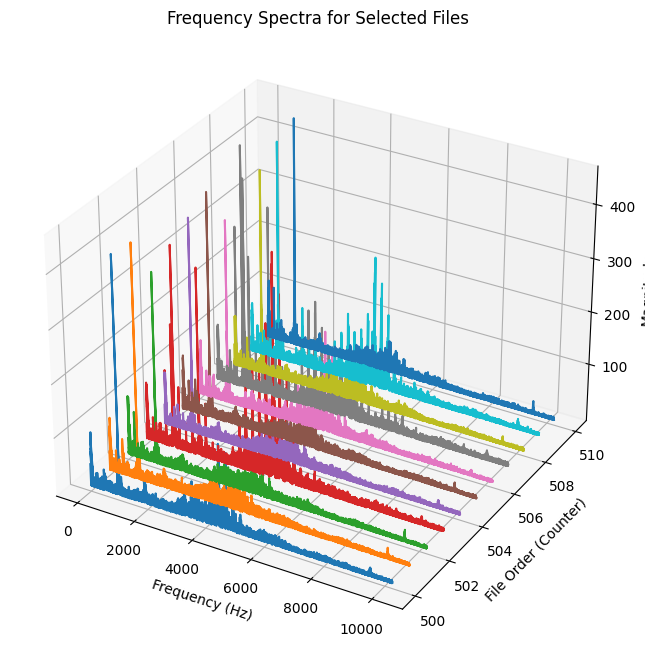

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

'''
def get_fft_frequencies_and_magnitudes(signal, sampling_rate):
    n = len(signal)
    fft_values = np.fft.rfft(signal)
    magnitudes = np.abs(fft_values)
    frequencies = np.fft.rfftfreq(n, d=1/sampling_rate)
    return frequencies, magnitudes'''

def get_fault_amplitude(frequencies, magnitudes, fault_frequency):
    index = np.argmin(np.abs(frequencies - fault_frequency))
    return magnitudes[index]

def plot_3d_spectrum(path, f1, f2, fs):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    file_counter = 0

    for filename in os.listdir(path):
        file_counter += 1
        if 500 <= file_counter <= 510:  # Adjust as needed
            filepath = os.path.join(path, filename)
            if os.path.exists(filepath):
                dataset = pd.read_csv(filepath, sep='\t', header=None)
                vibration_data = np.array(dataset.iloc[:, 0])  # Adjust if needed
                frequencies, magnitudes = get_fft_frequencies_and_magnitudes(vibration_data, fs)

                # Print fault amplitudes for harmonics of f1 and f2
                num_harmonics = 4  # Adjust as needed
                for harmonic in range(1, num_harmonics + 1):
                    fault_amplitude_f1 = get_fault_amplitude(frequencies, magnitudes, f1 * harmonic)
                    fault_amplitude_f2 = get_fault_amplitude(frequencies, magnitudes, f2 * harmonic)
                    print(f"File {filename}, {harmonic}*f1 ({f1 * harmonic} Hz): {fault_amplitude_f1}")
                    print(f"File {filename}, {harmonic}*f2 ({f2 * harmonic} Hz): {fault_amplitude_f2}")

                # Plot
                ax.plot(frequencies, [file_counter]*len(frequencies), magnitudes)
            else:
                print(f"File {filename} does not exist.")

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('File Order (Counter)')
    ax.set_zlabel('Magnitude')
    ax.set_title("Frequency Spectra for Selected Files")
    plt.show()

# Set your parameters
#path = '/your/directory/path'  # Replace with your directory path
fs = 20480  # Your sampling rate
f1 = 297.2  # Replace with the actual value
f2 = 236.7 # Replace with the actual value

# Call the function
plot_3d_spectrum(path, f1, f2, fs)


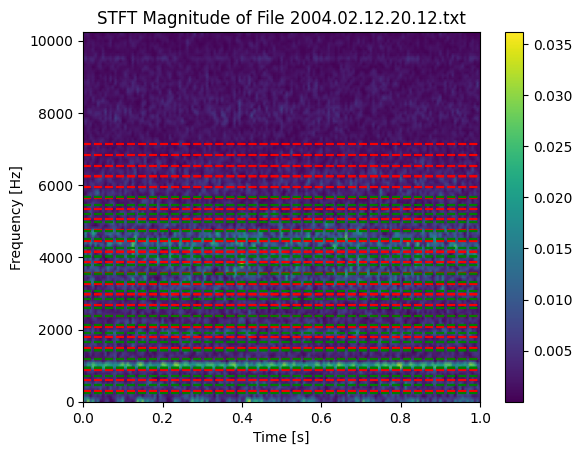

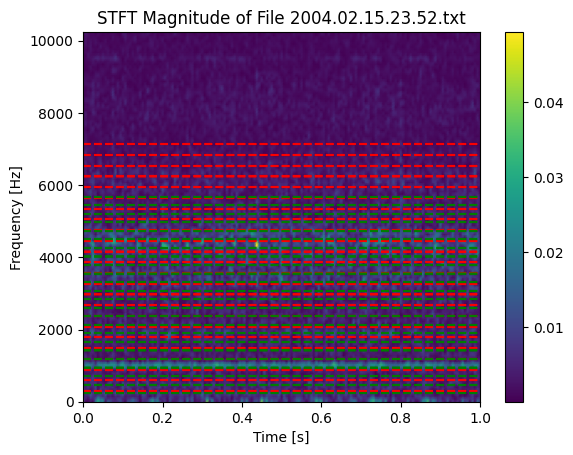

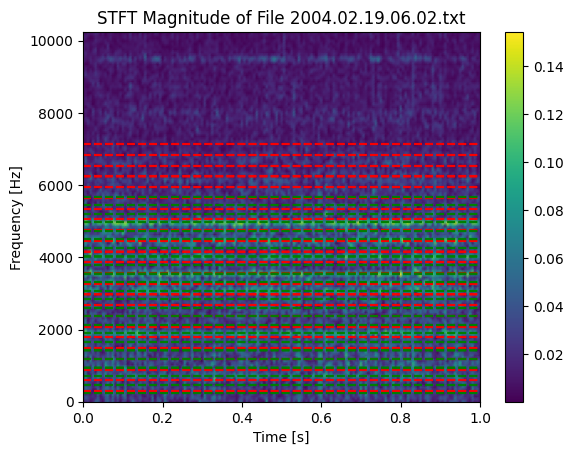

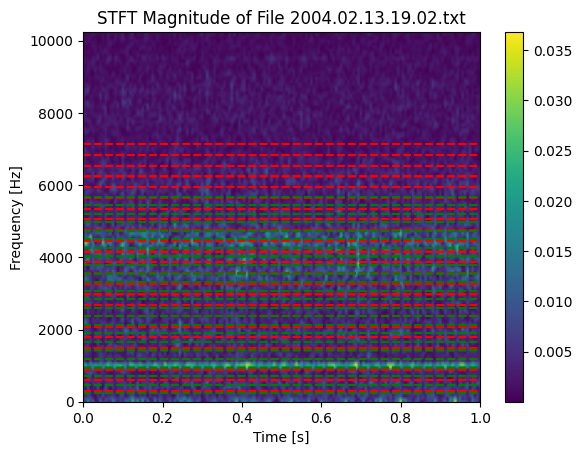

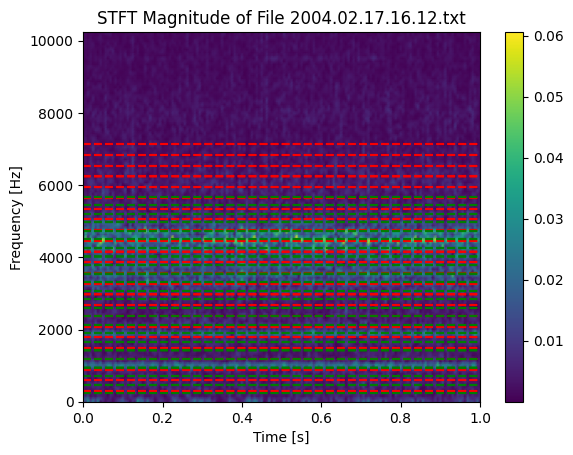

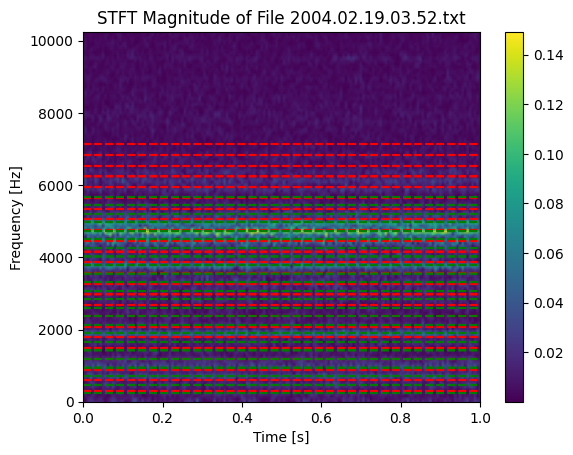

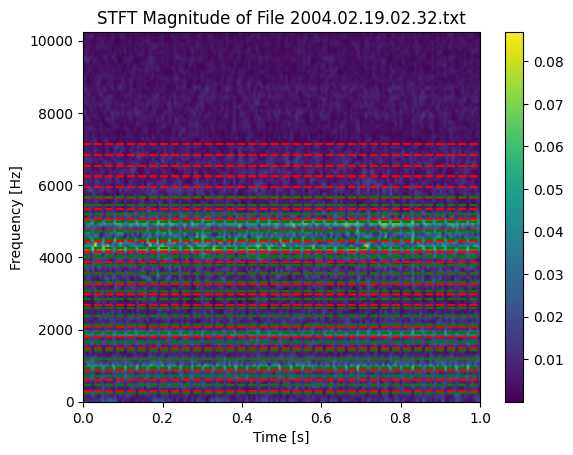

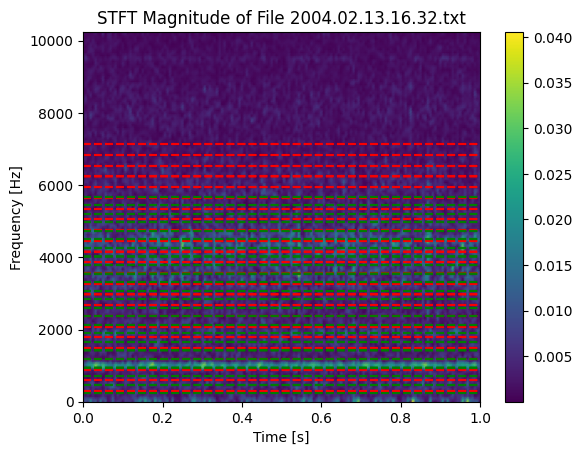

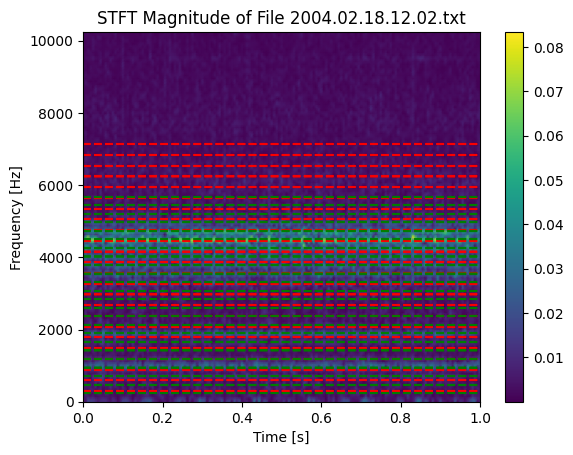

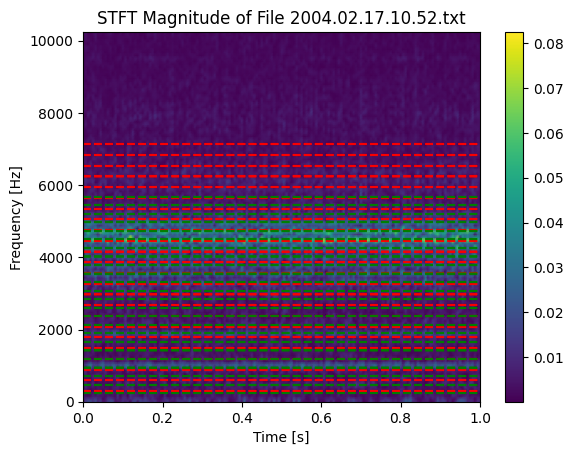

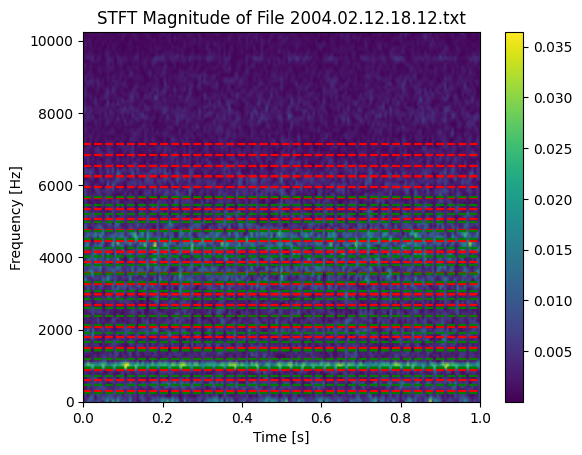

In [ ]:
#USING STFT
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import stft

def plot_stft_for_each_file(path, f1, f2, fs):
    file_counter = 0

    for filename in os.listdir(path):
        file_counter += 1
        if 510 <= file_counter <= 520:  # Adjust as needed
            filepath = os.path.join(path, filename)

            if os.path.exists(filepath):
                dataset = pd.read_csv(filepath, sep='\t', header=None)
                vibration_data = np.array(dataset.iloc[:, 0])  # Adjust if needed

                # Compute the Short-Time Fourier Transform of the signal
                f, t, Zxx = stft(vibration_data, fs, nperseg=256)  # Adjust nperseg as needed

                plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
                plt.title(f"STFT Magnitude of File {filename}")
                plt.xlabel("Time [s]")
                plt.ylabel("Frequency [Hz]")

                # Add lines indicating the harmonics of f1 and f2 and their variations
                for harmonic in range(1, 25):  # Adjust as needed
                    for variation in range(-2, 3):  # Adjust as needed
                        plt.axhline(y=(f1 * harmonic) + variation, color='r', linestyle='--', alpha=0.5)
                        plt.axhline(y=(f2 * harmonic) + variation, color='g', linestyle='--', alpha=0.5)

                plt.colorbar()
                plt.show()
            else:
                print(f"File {filename} does not exist.")


# Set your parameters
#path = '/your/directory/path'  # Replace with your directory path
fs = 20480  # Your sampling rate
f1 = 297.2  # Replace with the actual value
f2 = 236.7 # Replace with the actual value

# Call the function
plot_stft_for_each_file(path, f1, f2, fs)


/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


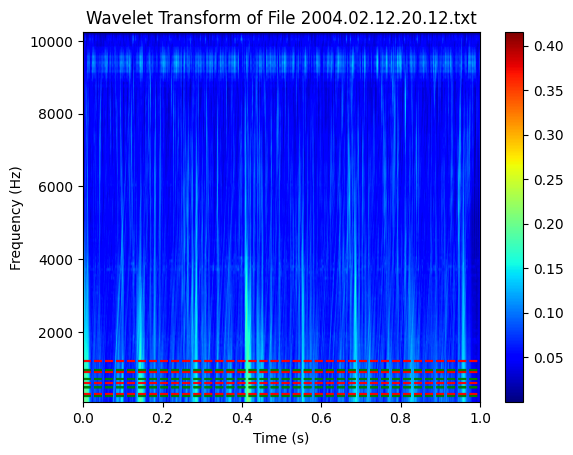

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


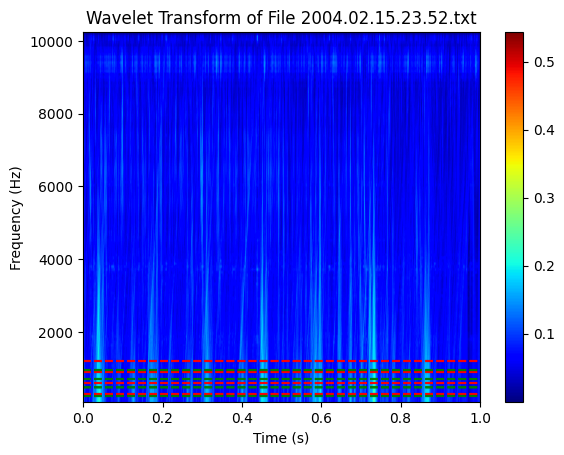

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


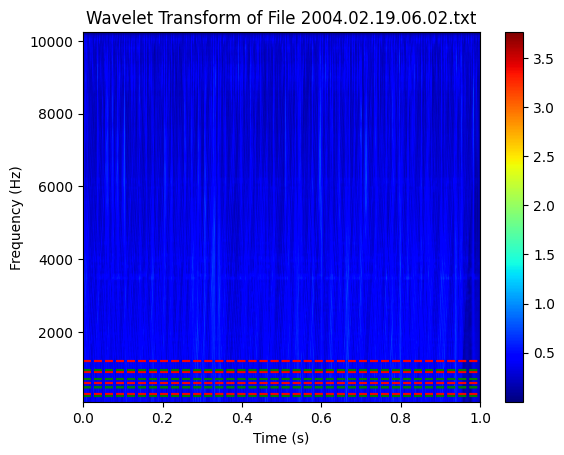

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


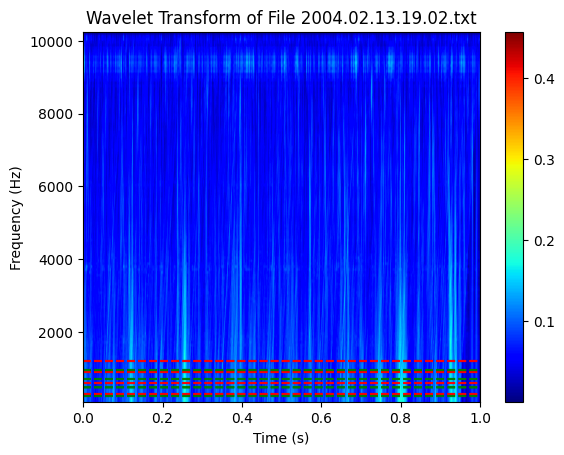

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


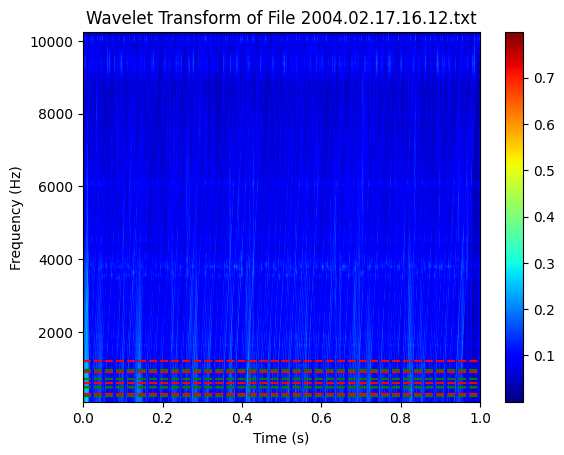

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


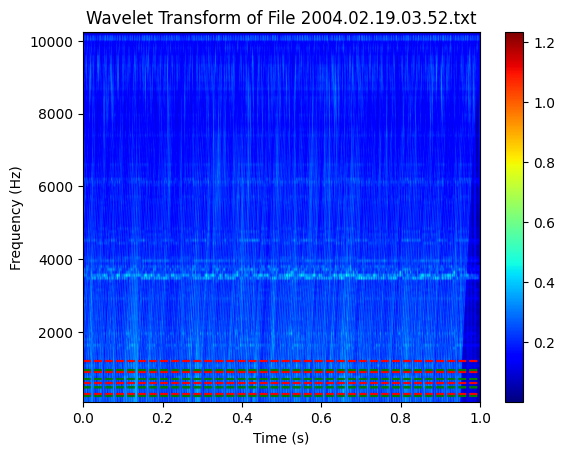

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


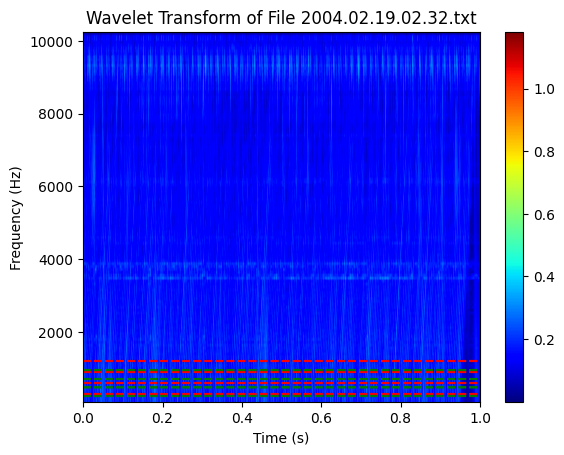

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


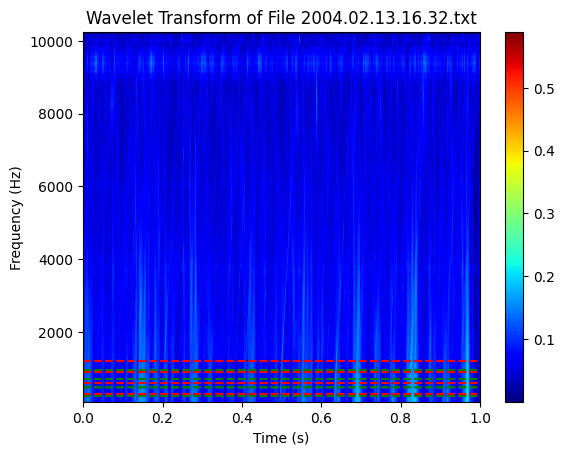

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


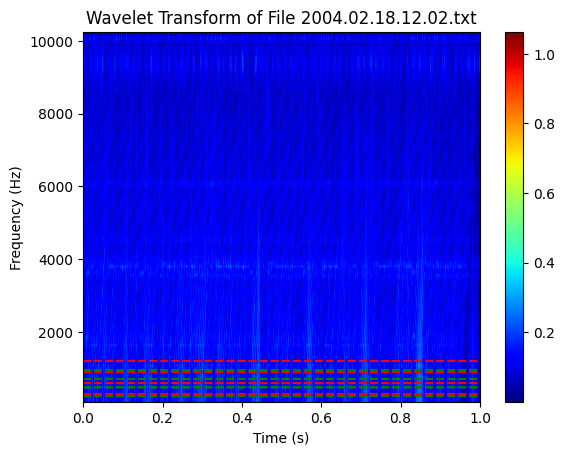

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


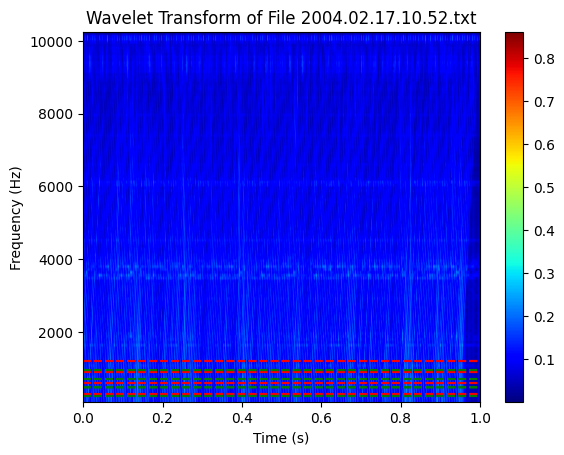

/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


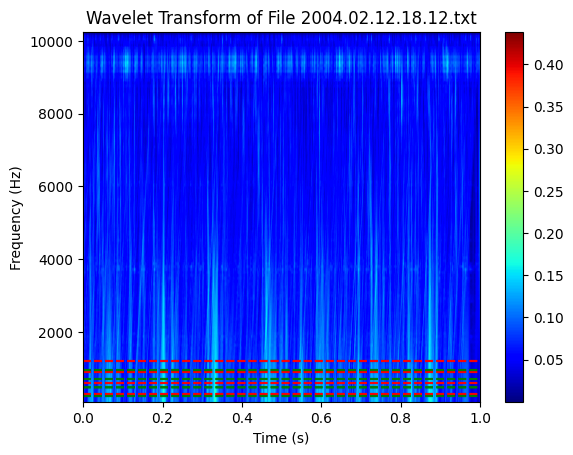

In [ ]:
#USING CWT
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pywt

def plot_cwt_for_each_file(path, f1, f2, fs):
    file_counter = 0

    for filename in os.listdir(path):
        file_counter += 1
        if 510 <= file_counter <= 520:  # Adjust as needed
          filepath = os.path.join(path, filename)

          if os.path.exists(filepath):
             dataset = pd.read_csv(filepath, sep='\t', header=None)
             vibration_data = np.array(dataset.iloc[:, 0])  # Adjust if needed

                # Compute the Continuous Wavelet Transform of the signal
               # Compute the Continuous Wavelet Transform of the signal
             widths = np.arange(1, 128)  # Adjust as needed
             cwtmatr, freqs = pywt.cwt(vibration_data, widths, 'cmor', 1/fs)

# Take the magnitude (absolute value) of the CWT matrix
             cwtmatr_abs = np.abs(cwtmatr)

             plt.imshow(cwtmatr_abs, extent=[0, len(vibration_data)/fs, freqs.min(), freqs.max()], cmap='jet', aspect='auto')
             plt.colorbar()
             plt.title(f"Wavelet Transform of File {filename}")
             plt.xlabel("Time (s)")
             plt.ylabel("Frequency (Hz)")

# Add lines indicating the harmonics of f1 and f2 and their variations
             for harmonic in range(1, 5):  # Adjust as needed
                    for variation in range(-2, 3):  # Adjust as needed
                          plt.axhline(y=(f1 * harmonic) + variation, color='r', linestyle='--', alpha=0.5)
                          plt.axhline(y=(f2 * harmonic) + variation, color='g', linestyle='--', alpha=0.5)

             plt.show()



# Set your parameters
#path = '/your/directory/path'  # Replace with your directory path
fs = 20480  # Your sampling rate
f1 = 297.2  # Replace with the actual value
f2 = 236.7 # Replace with the actual value

# Call the function
plot_cwt_for_each_file(path, f1, f2, fs)


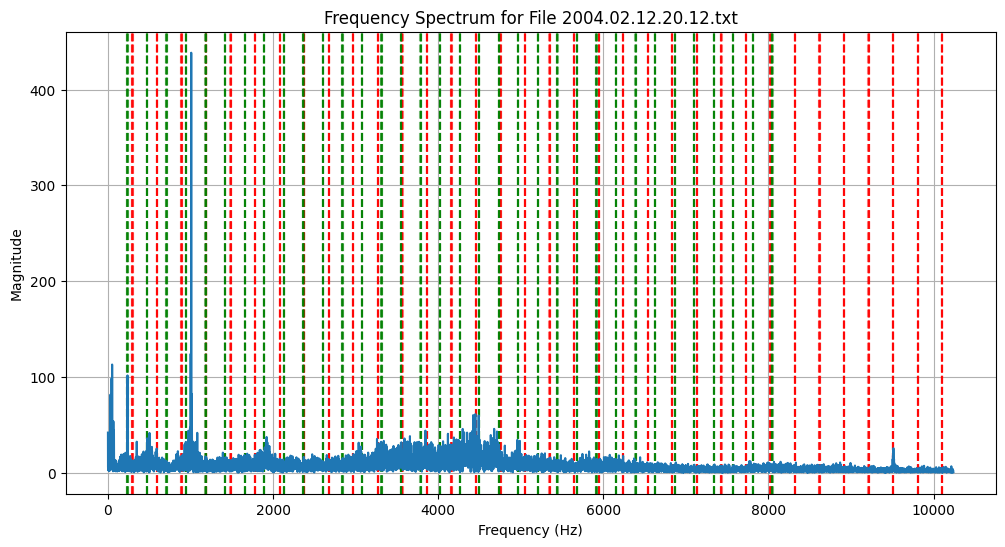

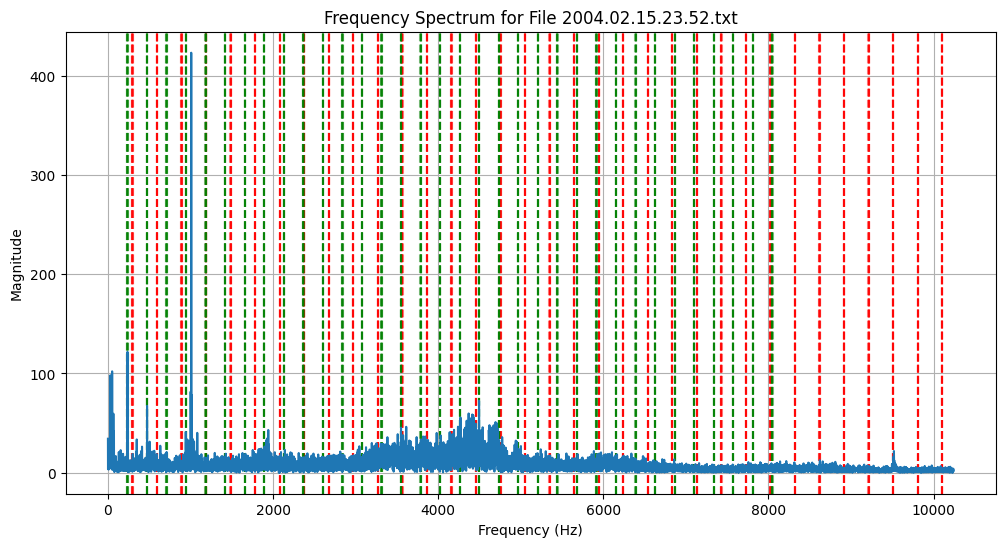

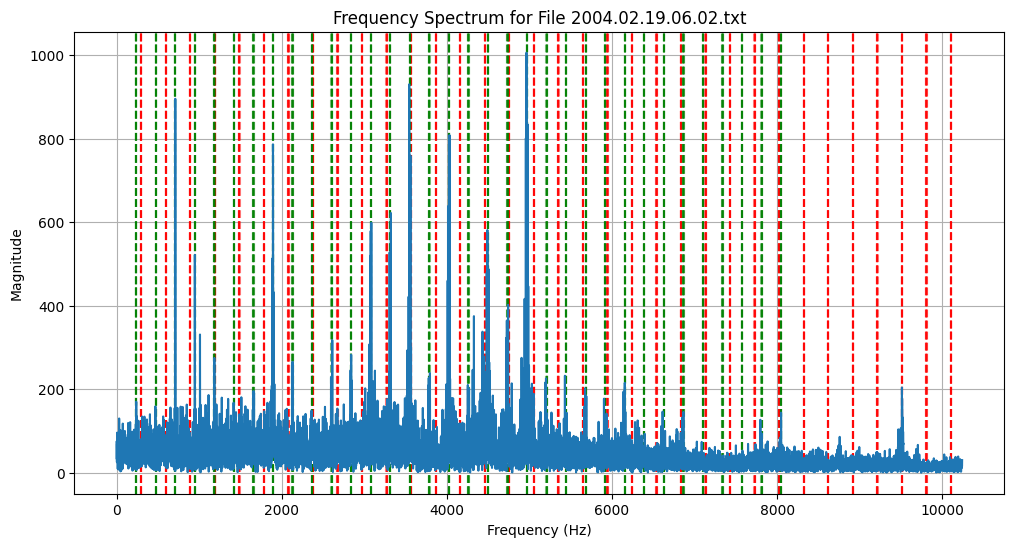

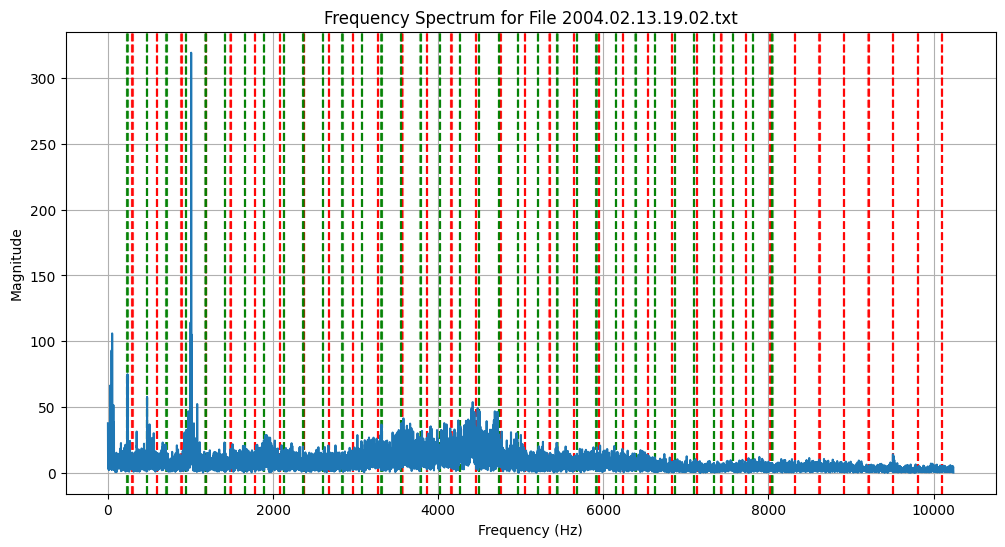

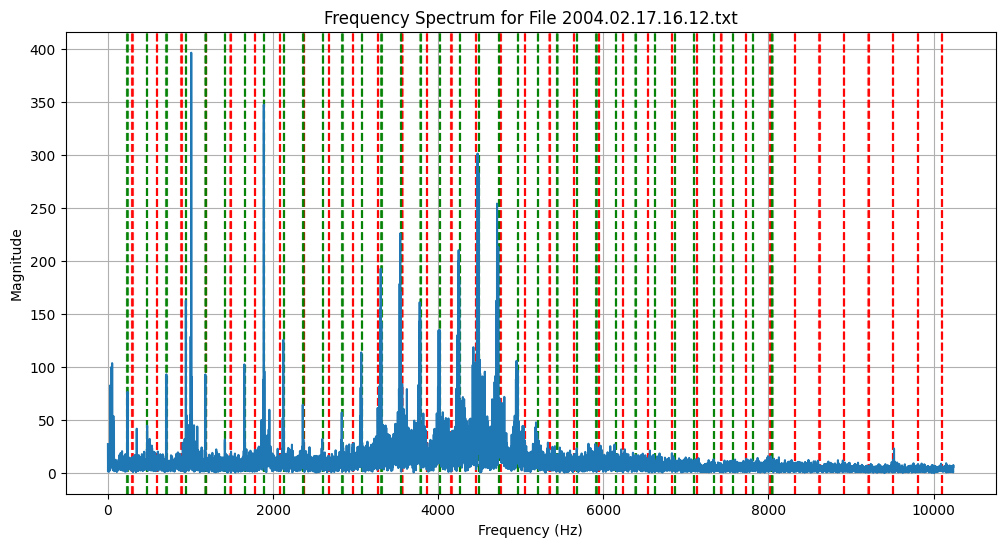

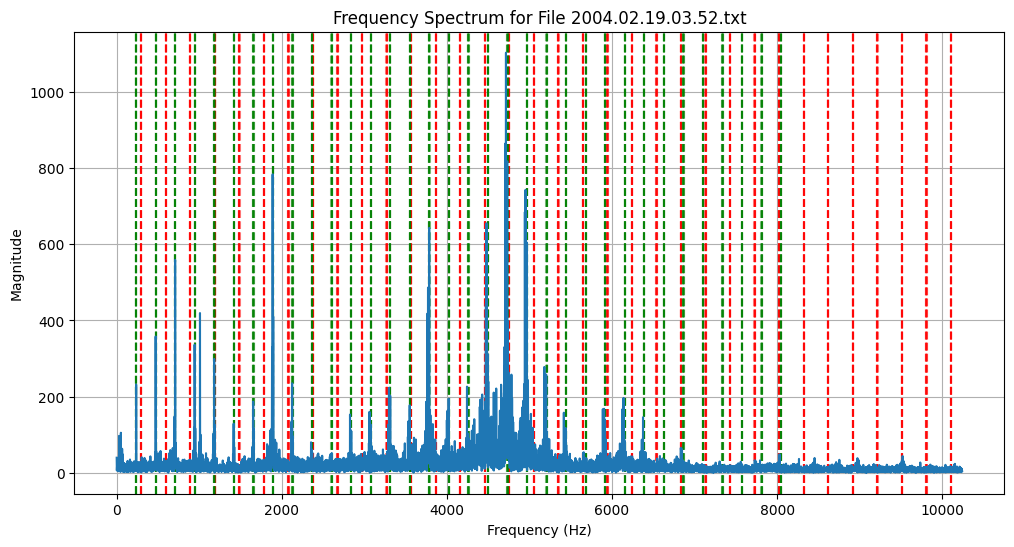

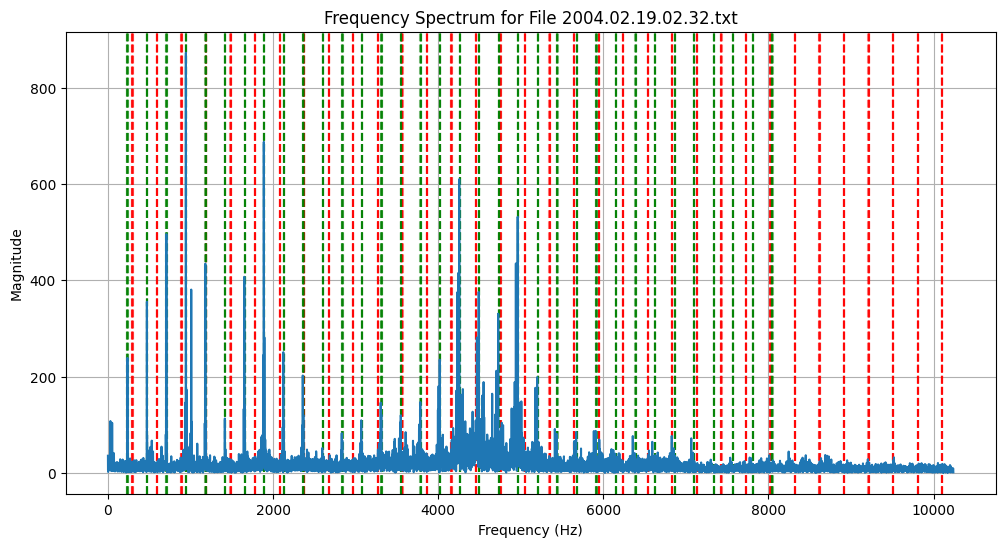

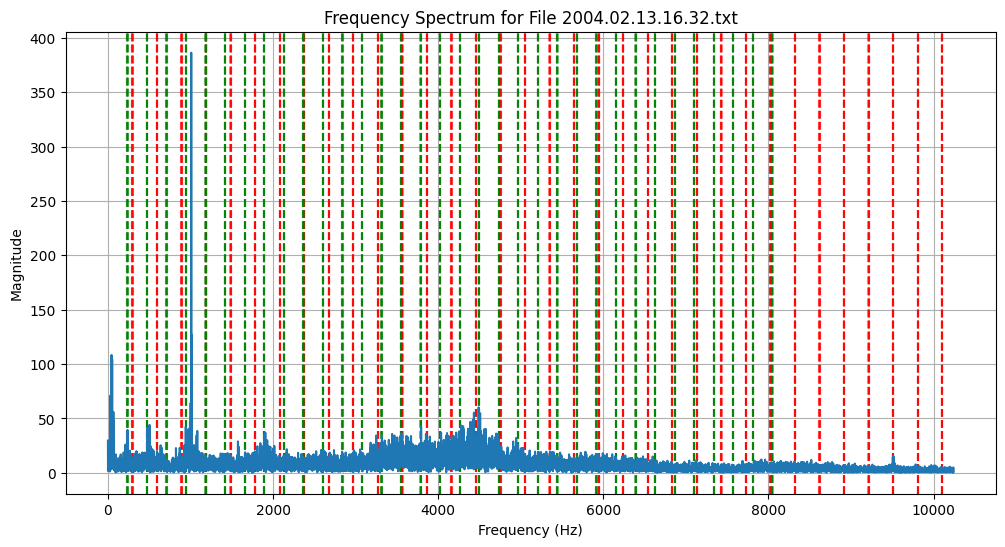

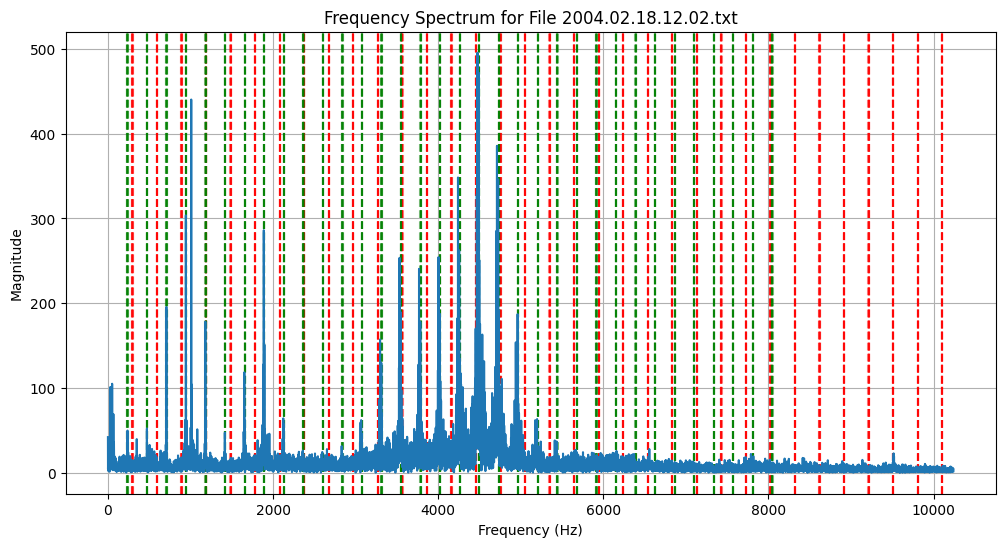

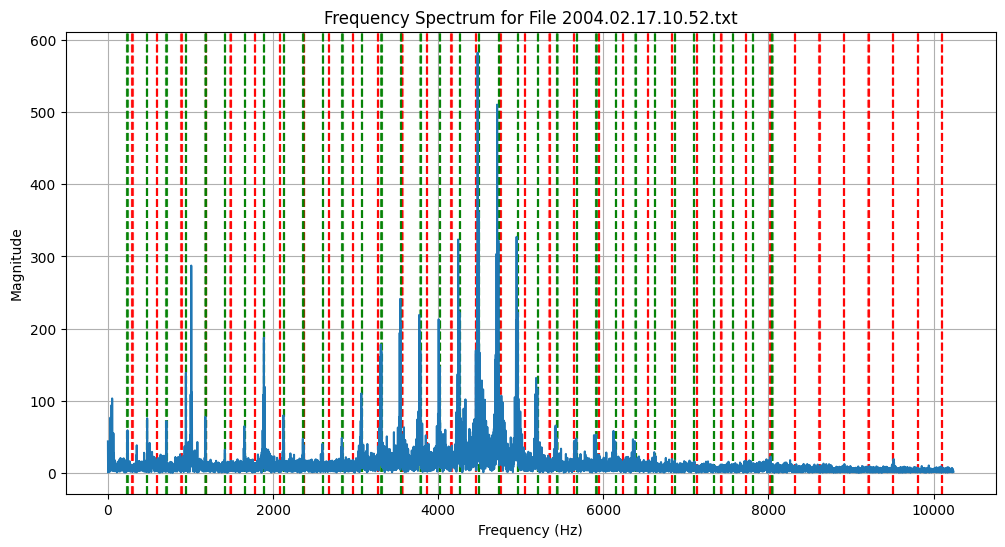

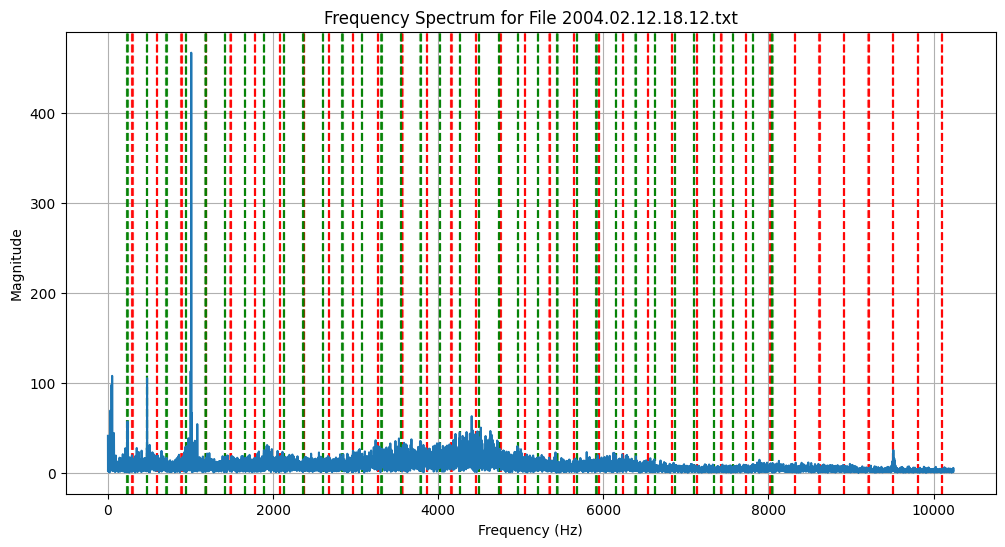

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Function to calculate and return frequencies and magnitudes from FFT of the signal
def get_fft_frequencies_and_magnitudes(signal, sampling_rate):
    n = len(signal)  # Get the length of the signal
    fft_values = np.fft.rfft(signal)  # Compute the one-dimensional n-point discrete Fourier Transform for real input
    magnitudes = np.abs(fft_values)  # Calculate the absolute values (magnitudes) of the complex numbers
    frequencies = np.fft.rfftfreq(n, d=1/sampling_rate)  # Discrete Fourier Transform sample frequencies
    return frequencies, magnitudes

# Function to find and return the amplitude of a specific fault frequency
def get_fault_amplitude(frequencies, magnitudes, fault_frequency):
    index = np.argmin(np.abs(frequencies - fault_frequency))  # Find index where the difference between frequencies and fault_frequency is minimum
    return magnitudes[index]  # Return the magnitude at the found index

# Function to plot frequency spectrum for each file, marking fault frequencies for harmonics of f1 and f2
def plot_spectrum_for_each_file(path, f1, f2, fs):
    file_counter = 0  # Initialize file counter

    # Iterate over files in specified directory
    for filename in os.listdir(path):
        file_counter += 1  # Increment file counter

        # Process files with counter values between 510 and 520
        if 510 <= file_counter <= 520:
            filepath = os.path.join(path, filename)  # Construct file path

            # Check if file exists
            if os.path.exists(filepath):
                # Load data from file
                dataset = pd.read_csv(filepath, sep='\t', header=None)
                vibration_data = np.array(dataset.iloc[:, 0])  # Extract vibration data

                # Get frequencies and magnitudes using FFT
                frequencies, magnitudes = get_fft_frequencies_and_magnitudes(vibration_data, fs)

                # Set up plot
                plt.figure(figsize=(12,6))

                # Iterate over harmonics and variations for fault frequencies
                for harmonic in range(1, 35):
                    for variation in range(-2, 3):
                        # Calculate and print fault amplitudes
                        fault_amplitude_f1 = get_fault_amplitude(frequencies, magnitudes, (f1 * harmonic) + variation)
                        fault_amplitude_f2 = get_fault_amplitude(frequencies, magnitudes, (f2 * harmonic) + variation)

                        # Mark fault frequencies on plot
                        plt.axvline(x=(f1 * harmonic) + variation, color='r', linestyle='--', alpha=0.5)
                        plt.axvline(x=(f2 * harmonic) + variation, color='g', linestyle='--', alpha=0.5)

                # Plot frequency spectrum
                plt.plot(frequencies, magnitudes)
                plt.title(f"Frequency Spectrum for File {filename}")  # Add title
                plt.xlabel("Frequency (Hz)")  # Label x-axis
                plt.ylabel("Magnitude")  # Label y-axis
                plt.grid(True)  # Add gridlines
                plt.show()  # Show plot

# Set parameters
fs = 20480  # Set sampling rate
f1 = 297.2  # Set fault frequency f1
f2 = 236.7  # Set fault frequency f2

# Call function to plot spectrum for each file
plot_spectrum_for_each_file(path, f1, f2, fs)


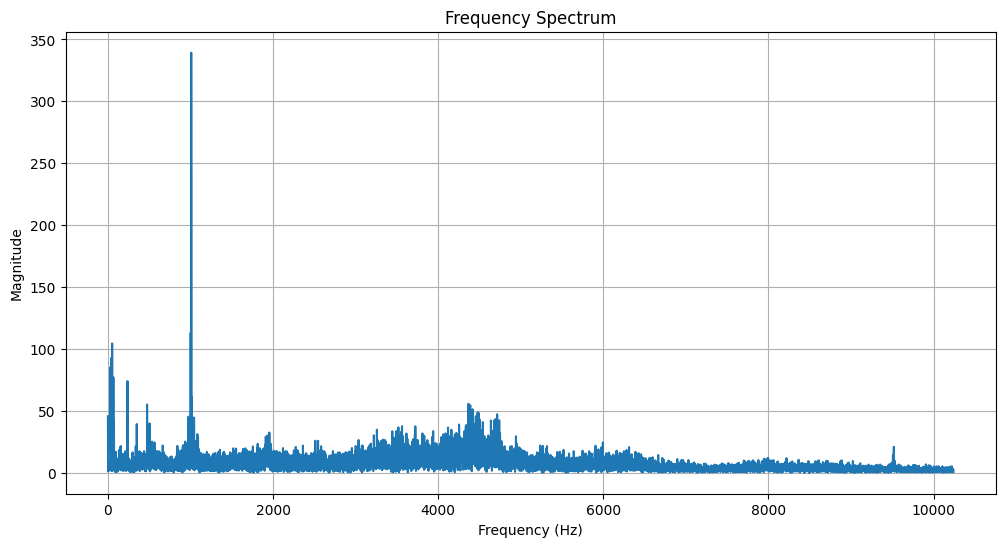

In [ ]:

def get_fft_frequencies_and_magnitudes(signal, sampling_rate):
    # Compute FFT
    n = len(signal)
    fft_values = np.fft.rfft(signal)
    magnitudes = np.abs(fft_values)

    # Compute the frequencies
    frequencies = np.fft.rfftfreq(n, d=1/sampling_rate)

    return frequencies, magnitudes

def plot_spectrum(frequencies, magnitudes):
    plt.figure(figsize=(12,6))
    plt.plot(frequencies, magnitudes)
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

# Assuming vibration_data is your signal and fs is the sampling rate
fs = 20480  # Your sampling rate
frequencies, magnitudes = get_fft_frequencies_and_magnitudes(vibration_data, fs)
plot_spectrum(frequencies, magnitudes)


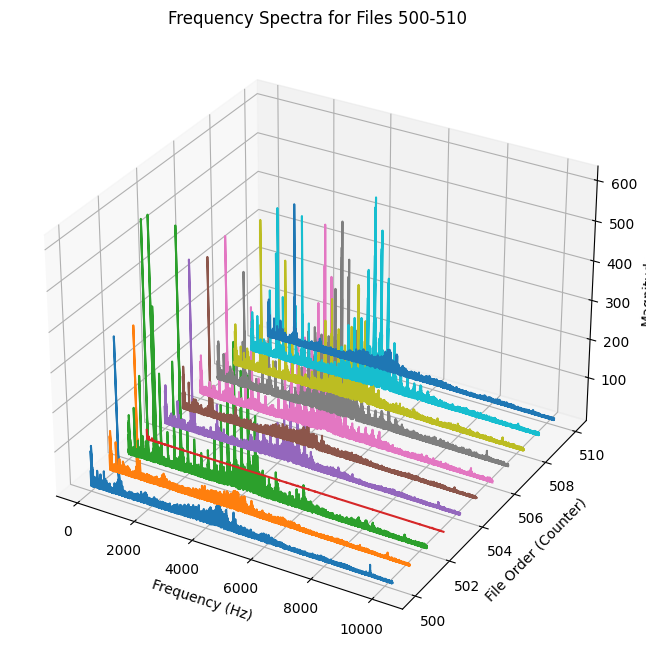

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

# Your provided functions remain unchanged...

# Process files in groups and plot in 3D
path = '/content/IMS-3/nasaT2'  # Replace with your directory path

from mpl_toolkits.mplot3d import Axes3D


fs = 20480  # Your sampling rate

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Counter for processed files
file_counter = 0

# Iterate through files in the directory as they appear
for filename in os.listdir(path):
    # Increment the counter
    file_counter += 1

    # Only process files when the counter is between 500 and 510
    if 500 <= file_counter <= 510:
        filepath = os.path.join(path, filename)

        if os.path.exists(filepath):
            dataset = pd.read_csv(filepath, sep='\t', header=None)
            original_signal = np.array(dataset.iloc[:, 0])

            # Transform the original signal into the frequency spectrum
            frequencies, magnitudes = get_fft_frequencies_and_magnitudes(original_signal, fs)

            # Use the counter to represent the file order on the y-axis
            ax.plot(frequencies, [file_counter]*len(frequencies), magnitudes)
        else:
            print(f"File {filename} does not exist.")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('File Order (Counter)')
ax.set_zlabel('Magnitude')
ax.set_title("Frequency Spectra for Files 500-510")
plt.show()


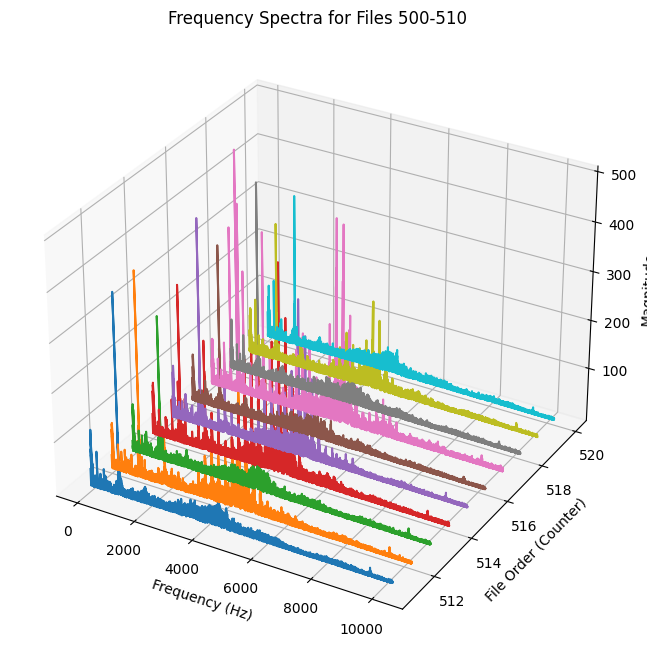

In [ ]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Counter for processed files
file_counter = 0

# Iterate through files in the directory as they appear
for filename in os.listdir(path):
    # Increment the counter
    file_counter += 1

    # Only process files when the counter is between 500 and 510
    if 511 <= file_counter <= 520:
        filepath = os.path.join(path, filename)

        if os.path.exists(filepath):
            dataset = pd.read_csv(filepath, sep='\t', header=None)
            original_signal = np.array(dataset.iloc[:, 0])

            # Transform the original signal into the frequency spectrum
            frequencies, magnitudes = get_fft_frequencies_and_magnitudes(original_signal, fs)

            # Use the counter to represent the file order on the y-axis
            ax.plot(frequencies, [file_counter]*len(frequencies), magnitudes)
        else:
            print(f"File {filename} does not exist.")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('File Order (Counter)')
ax.set_zlabel('Magnitude')
ax.set_title("Frequency Spectra for Files 500-510")
plt.show()


In [ ]:
if file_counter == 980:  # This will be the 981th file
    plt.figure(figsize=(15, 5))

    # Plot for Raw Signal
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(t, vibration_data, label="Raw Signal", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Amplitude vs Time for {filename} (Raw Signal)")
    plt.legend()
    plt.grid(True)

    # Plot for Reconstructed Signal
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(t, reconstructed_signal, label="Reconstructed Signal", color='green')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Amplitude vs Time for {filename} (Reconstructed Signal)")
    plt.legend()
    plt.grid(True)

    # Plot for Envelope Analysis
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(t, amplitude_envelope, label="Amplitude Envelope", color='red')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Envelope Analysis for {filename}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjusts the layout so that the plots do not overlap
    plt.show()


In [ ]:
!pip install pyhht


In [ ]:
print(All_new_feature_matrix.shape[1])  # This will print the number of columns


38


In [ ]:
#FEATURE MATRIX
feature_names = [
    'Max', 'Min', 'Mean', 'Std','Sqrt','Skewness', 'Kurtosis', 'Peak-to-Peak',
    'Absolute Energy', 'Global Value', 'Principal Frequency', '25th Percentile',
    'Median', '75th Percentile', 'Activity', 'Mobility',
    'Complexity', 'Rate of Zero Crossing', 'Entropy', 'Histogram Upper Bound',
    'Histogram Lower Bound', 'Weibull Negative Log Likelihood',
    'Gaussian Negative Log Likelihood', 'Rényi Entropy (α=0.1)',
    'Rényi Entropy (α=0.5)', 'Rényi Entropy (α=1.0)', 'Rényi Entropy (α=2.0)', 'Crest Factor',
    'Shape Factor', 'Impulse Factor', 'Clearance Factor', 'Skewness Factor',
    'Kurtosis Factor', 'Geometric Mean', 'Root Sum of Squares (RSSQ)',
    'Mean Absolute Deviation', 'Median Absolute Deviation', 'RMS',
]
All_new_feature_matrix.columns = feature_names
All_new_feature_matrix


Max        Min      Mean        Std       Sqrt  \
2004.02.15.07.42  31.142495 -35.037877 -0.187728   7.371130   7.373340   
2004.02.16.08.22  45.434191 -35.895057 -0.225230   8.478326   8.481110   
2004.02.17.08.32  81.875945 -73.335893 -0.183687  15.944265  15.944934   
2004.02.12.13.02  33.855427 -35.315128 -0.150579   7.531119   7.532440   
2004.02.12.23.02  36.517121 -32.491402 -0.204091   7.426650   7.429273   
...                     ...        ...       ...        ...        ...   
2004.02.13.18.42  39.424665 -39.009321 -0.223461   7.428760   7.431939   
2004.02.16.18.02  46.421954 -52.142247 -0.173119   9.374097   9.375466   
2004.02.14.20.22  39.912271 -43.579567 -0.193132   7.531659   7.533951   
2004.02.16.23.12  41.583372 -43.252075 -0.212835   9.917941   9.919983   
2004.02.14.06.22  34.533435 -35.235913 -0.220937   7.241611   7.244804   

                  Skewness  Kurtosis  Peak-to-Peak  Absolute Energy  \
2004.02.15.07.42 -0.094989  3.364780     35.037001        54.366144   
2004.02.16.08.22 -0.094219  3.414034     45.434144        71.929234   
2004.02.17.08.32 -0.163534  5.436590     81.875941       254.240905   
2004.02.12.13.02 -0.073144  3.517313     35.314574        56.737652   
2004.02.12.23.02 -0.073094  3.301913     36.516881        55.194094   
...                    ...       ...           ...              ...   
2004.02.13.18.42 -0.102031  3.481230     39.424458        55.233714   
2004.02.16.18.02 -0.047748  3.582859     52.141734        87.899368   
2004.02.14.20.22 -0.119918  3.511186     43.579333        56.760423   
2004.02.16.23.12 -0.105946  3.753184     43.251689        98.406053   
2004.02.14.06.22 -0.098699  3.282669     35.235911        52.487179   

                  Global Value  ...  Shape Factor  Impulse Factor  \
2004.02.15.07.42     47.093786  ...      1.266238        5.348162   
2004.02.16.08.22     46.008777  ...      1.271920        6.813810   
2004.02.17.08.32     88.384544  ...      1.432512        7.355832   
2004.02.12.13.02     37.940895  ...      1.274252        5.727272   
2004.02.12.23.02     38.796480  ...      1.264119        6.213528   
...                        ...  ...           ...             ...   
2004.02.13.18.42     43.570463  ...      1.271318        6.744037   
2004.02.16.18.02     61.667953  ...      1.283422        6.354772   
2004.02.14.20.22     46.387640  ...      1.267573        6.715166   
2004.02.16.23.12     47.414519  ...      1.301856        5.457225   
2004.02.14.06.22     35.184322  ...      1.264600        6.027902   

                  Clearance Factor  Skewness Factor  Kurtosis Factor  \
2004.02.15.07.42         11.468887        -0.012887         0.061928   
2004.02.16.08.22         15.601144        -0.011113         0.047495   
2004.02.17.08.32         20.504301        -0.010257         0.021385   
2004.02.12.13.02         12.335605        -0.009712         0.062014   
2004.02.12.23.02         13.397488        -0.009842         0.059866   
...                            ...              ...              ...   
2004.02.13.18.42         14.461620        -0.013735         0.063081   
2004.02.16.18.02         15.160970        -0.005094         0.040773   
2004.02.14.20.22         14.541025        -0.015922         0.061897   
2004.02.16.23.12         13.202745        -0.010682         0.038155   
2004.02.14.06.22         12.829995        -0.013629         0.062597   

                  Geometric Mean  Root Sum of Squares (RSSQ)  \
2004.02.15.07.42        3.775072                 1055.186541   
2004.02.16.08.22        4.275953                 1213.717726   
2004.02.17.08.32        6.284270                 2281.853136   
2004.02.12.13.02        3.880794                 1077.955060   
2004.02.12.23.02        3.800637                 1063.190977   
...                          ...                         ...   
2004.02.13.18.42        3.771366                 1063.572503   
2004.02.16.18.02        4.681234                 1341.707515   
2004.02.14.2

In [ ]:
print(All_new_feature_matrix['Rényi Entropy (α=0.5)'][1])

11.938223368649872


In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
clf = IsolationForest(contamination=0.05)  # You can adjust the contamination parameter as needed

# Fit the model to your feature matrix
clf.fit(All_new_feature_matrix)

# Predict anomalies (outliers are marked with -1 and inliers with 1)
outliers = clf.predict(All_new_feature_matrix)

# Add the predictions to your DataFrame if desired
All_new_feature_matrix['Outlier'] = outliers


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
from google.colab import files

# Assuming All_new_feature_matrix is your DataFrame
All_new_feature_matrix.to_csv('All_new_feature_matrix.csv', index=False)

# Download the file to your local machine
files.download('All_new_feature_matrix.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

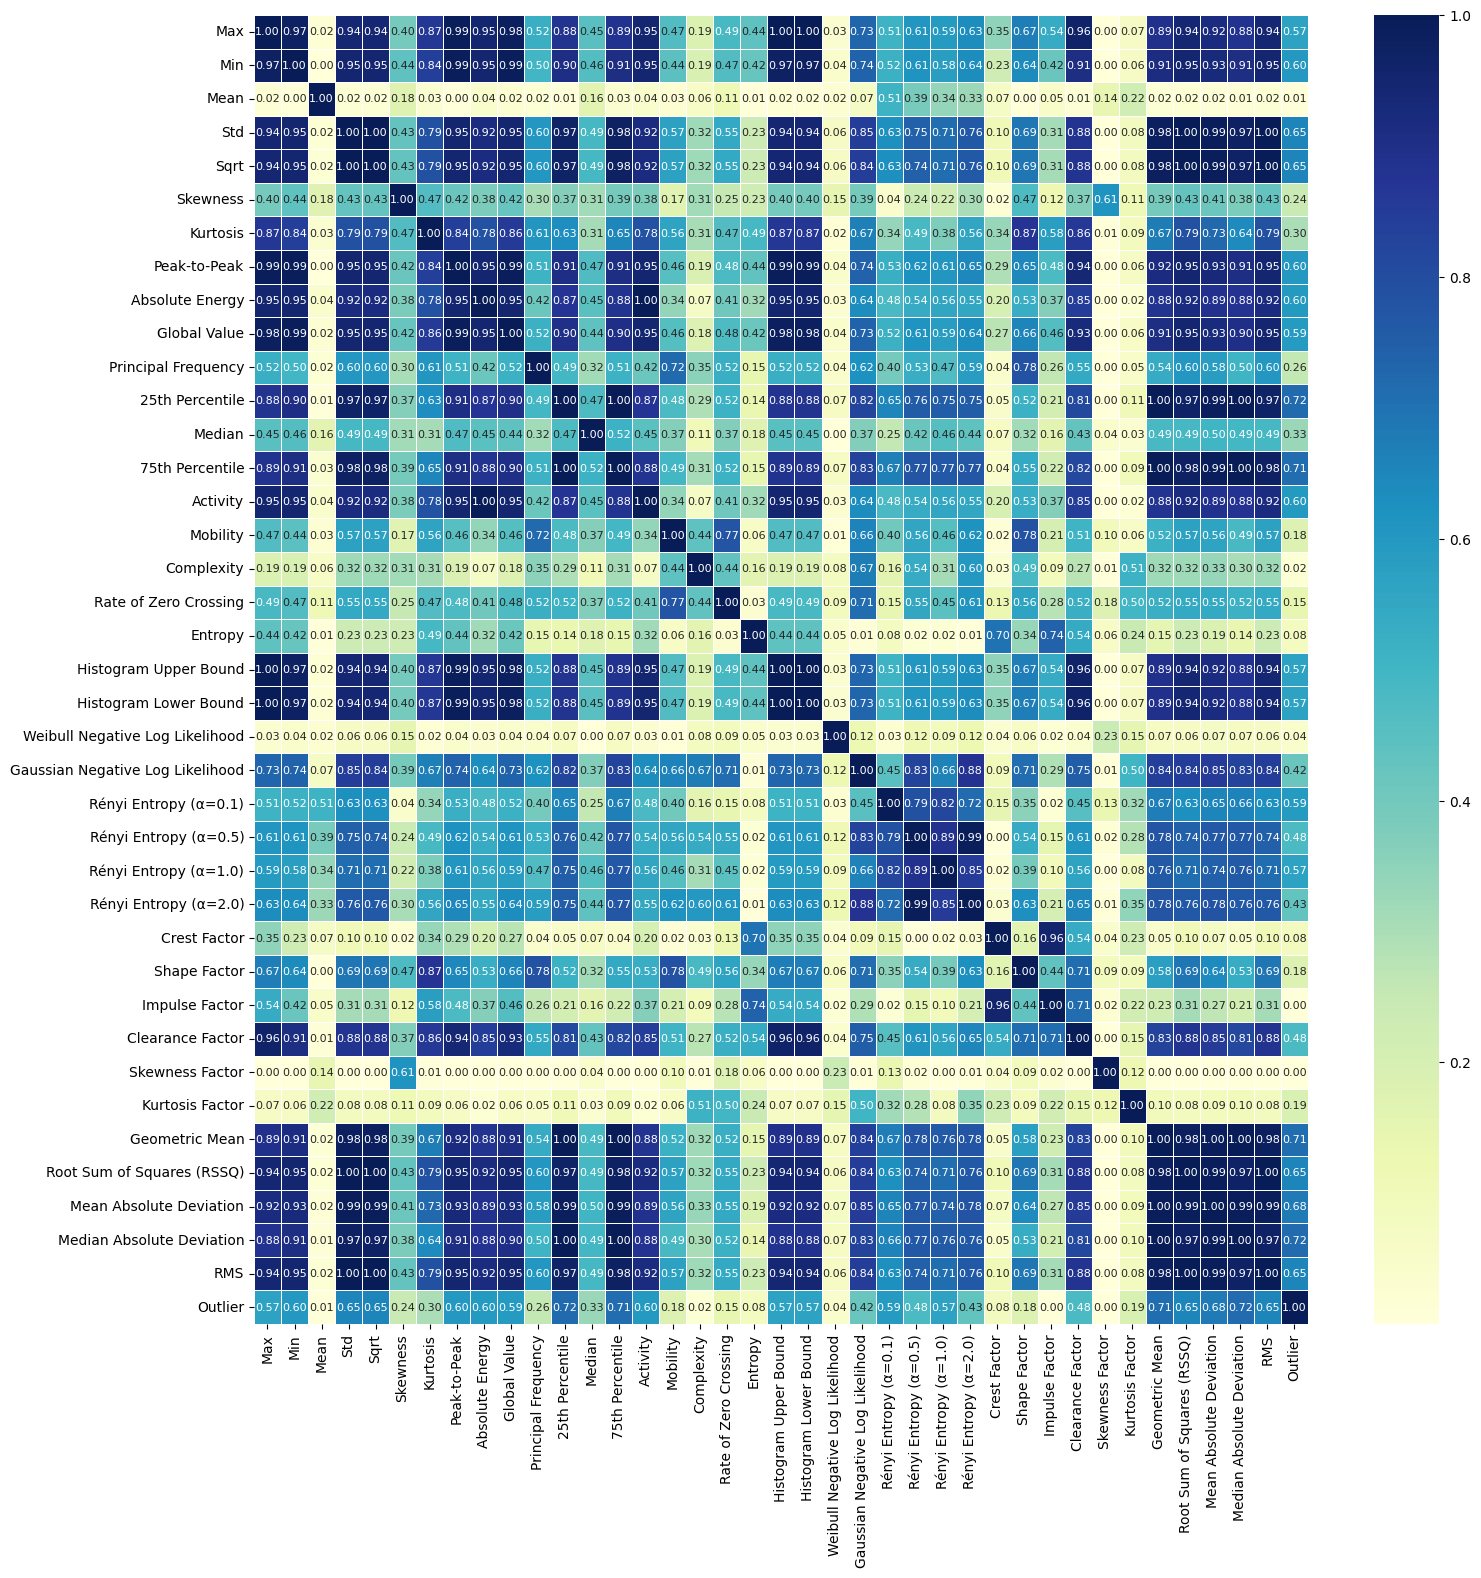

In [ ]:
#HEATMAPS
# Calculate the absolute correlation coefficients
corr = np.abs(All_new_feature_matrix.corr())

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(17, 17))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f",
            annot_kws={"size": 8}, linewidths=.5)

# Display the plot
plt.show()

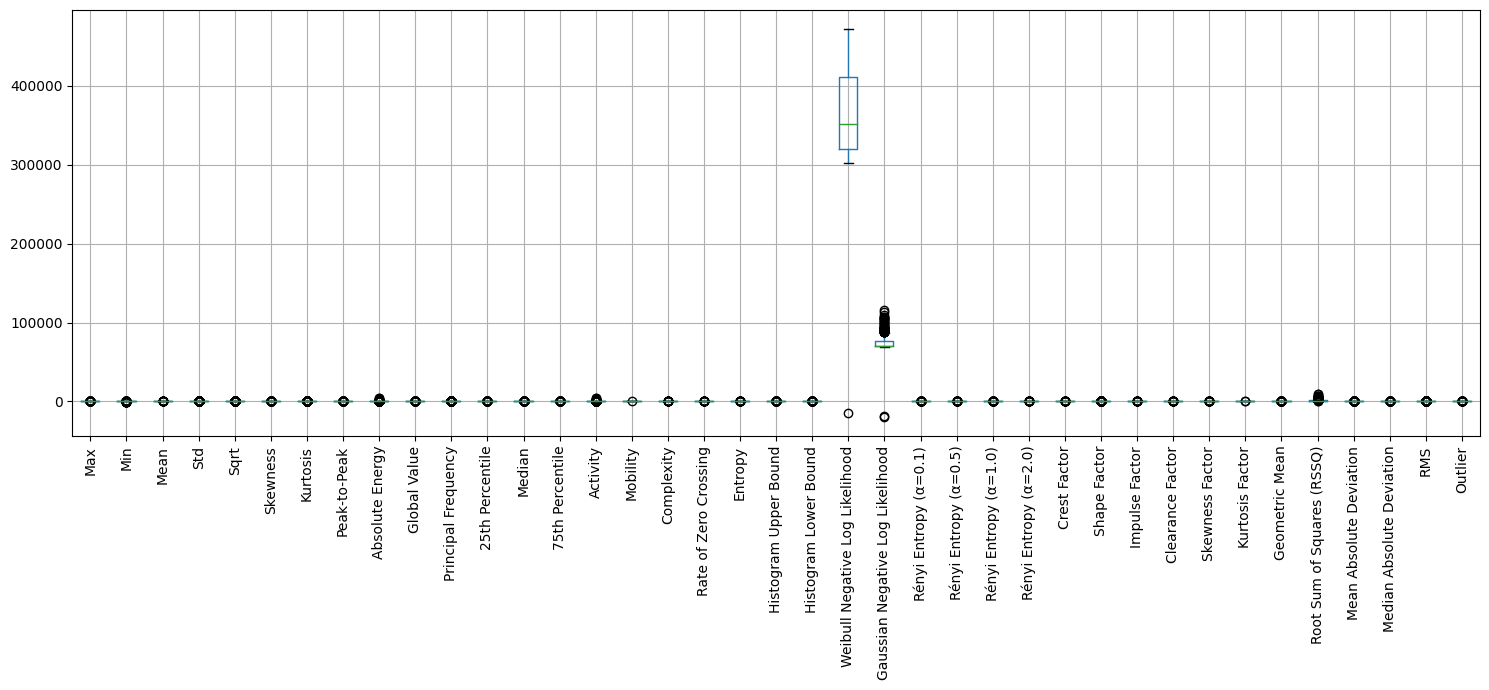

In [ ]:
#Box Plots
All_new_feature_matrix.boxplot(figsize=(15, 7), rot=90)
plt.tight_layout()
plt.show()


In [ ]:
print(os.listdir(path))

['2004.02.12.20.32.txt', '2004.02.12.14.02.txt', '2004.02.16.07.42.txt', '2004.02.13.08.22.txt', '2004.02.16.16.12.txt', '2004.02.17.00.42.txt', '2004.02.18.10.12.txt', '2004.02.18.11.12.txt', '2004.02.17.23.32.txt', '2004.02.13.19.02.txt', '2004.02.14.16.12.txt', '2004.02.13.15.22.txt', '2004.02.12.11.42.txt', '2004.02.15.12.32.txt', '2004.02.14.14.42.txt', '2004.02.17.06.02.txt', '2004.02.16.13.22.txt', '2004.02.19.01.12.txt', '2004.02.15.08.02.txt', '2004.02.18.23.12.txt', '2004.02.18.22.22.txt', '2004.02.14.09.42.txt', '2004.02.15.03.12.txt', '2004.02.17.05.02.txt', '2004.02.16.19.22.txt', '2004.02.17.09.22.txt', '2004.02.13.22.12.txt', '2004.02.17.20.22.txt', '2004.02.17.04.12.txt', '2004.02.13.02.22.txt', '2004.02.13.04.42.txt', '2004.02.17.05.52.txt', '2004.02.12.22.42.txt', '2004.02.16.04.02.txt', '2004.02.16.02.12.txt', '2004.02.18.01.52.txt', '2004.02.12.19.52.txt', '2004.02.18.03.42.txt', '2004.02.18.02.12.txt', '2004.02.15.08.52.txt', '2004.02.17.06.32.txt', '2004.02.13.10.

In [ ]:
'''# Spectrograms
f_original, t_original, Sxx_original = spectrogram(vibration_data, fs=1.0/(t[1]-t[0]))
f_reconstructed, t_reconstructed, Sxx_reconstructed = spectrogram(reconstructed_signal, fs=1.0/(t[1]-t[0]))
frequencies_spectrum = np.fft.fftfreq(len(t), t[1]-t[0])
original_spectrum = np.fft.fft(vibration_data)
reconstructed_spectrum = np.fft.fft(reconstructed_signal)'''

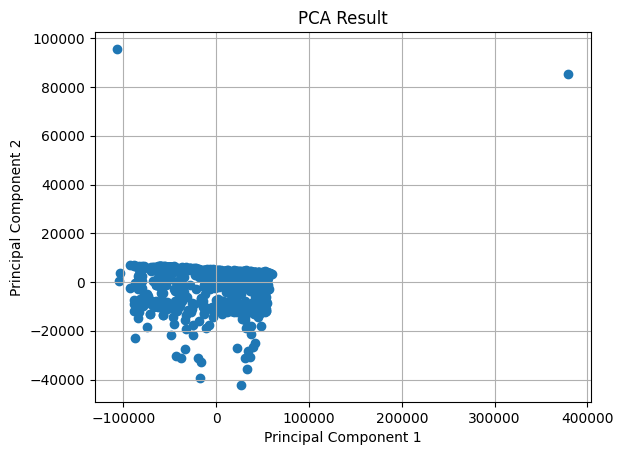

In [ ]:
from sklearn.decomposition import PCA
#pCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(All_new_feature_matrix.iloc[:, :38])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()


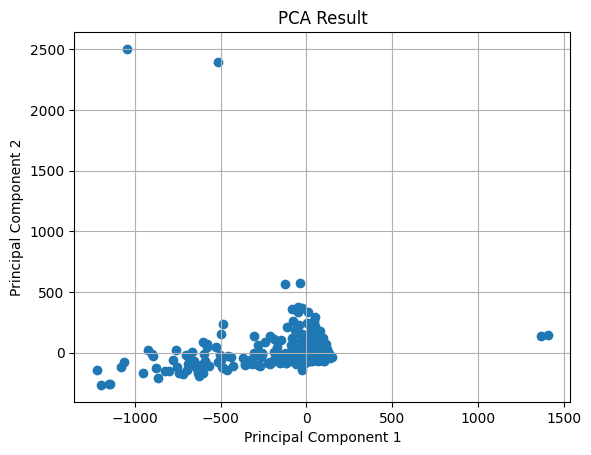

In [ ]:
from sklearn.decomposition import PCA

# Droping columns 22 and 23 (indexed as 21 and 22) and then select first 38 columns
selected_data = All_new_feature_matrix.drop(All_new_feature_matrix.columns[[21, 22]], axis=1).iloc[:, :38]

# PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(selected_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()


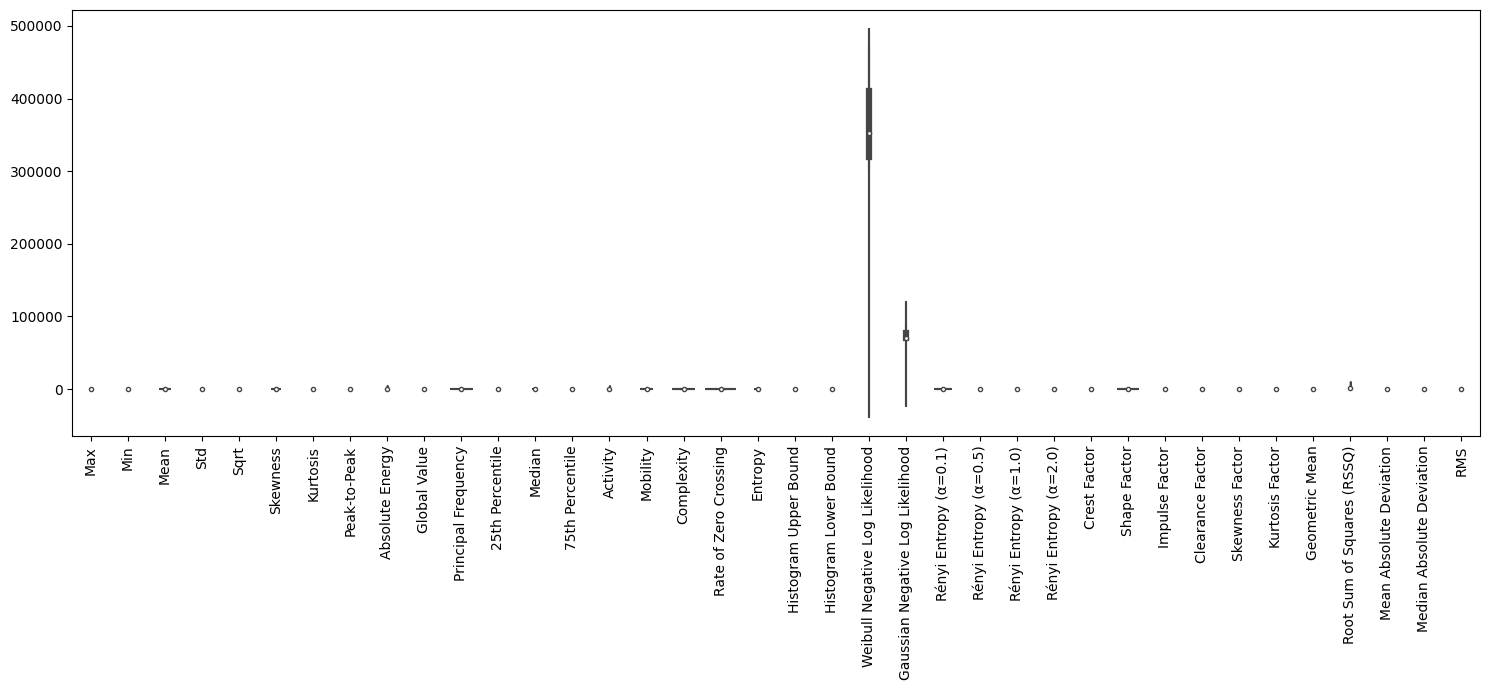

In [ ]:
plt.figure(figsize=(15,7))
sns.violinplot(data=All_new_feature_matrix.iloc[:, :38])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


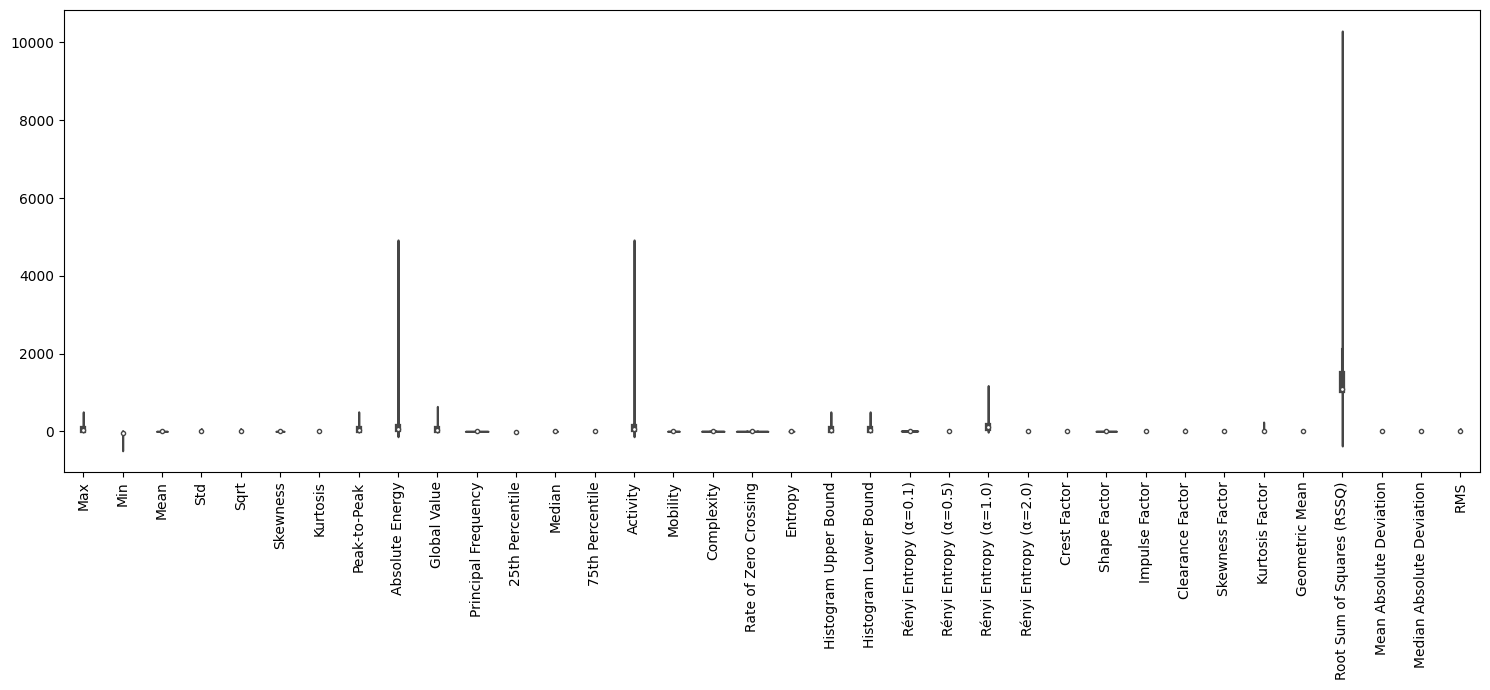

In [ ]:
plt.figure(figsize=(15,7))#dropping two columns
sns.violinplot(data=All_new_feature_matrix.drop(All_new_feature_matrix.columns[[21, 22]], axis=1).iloc[:, :38])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

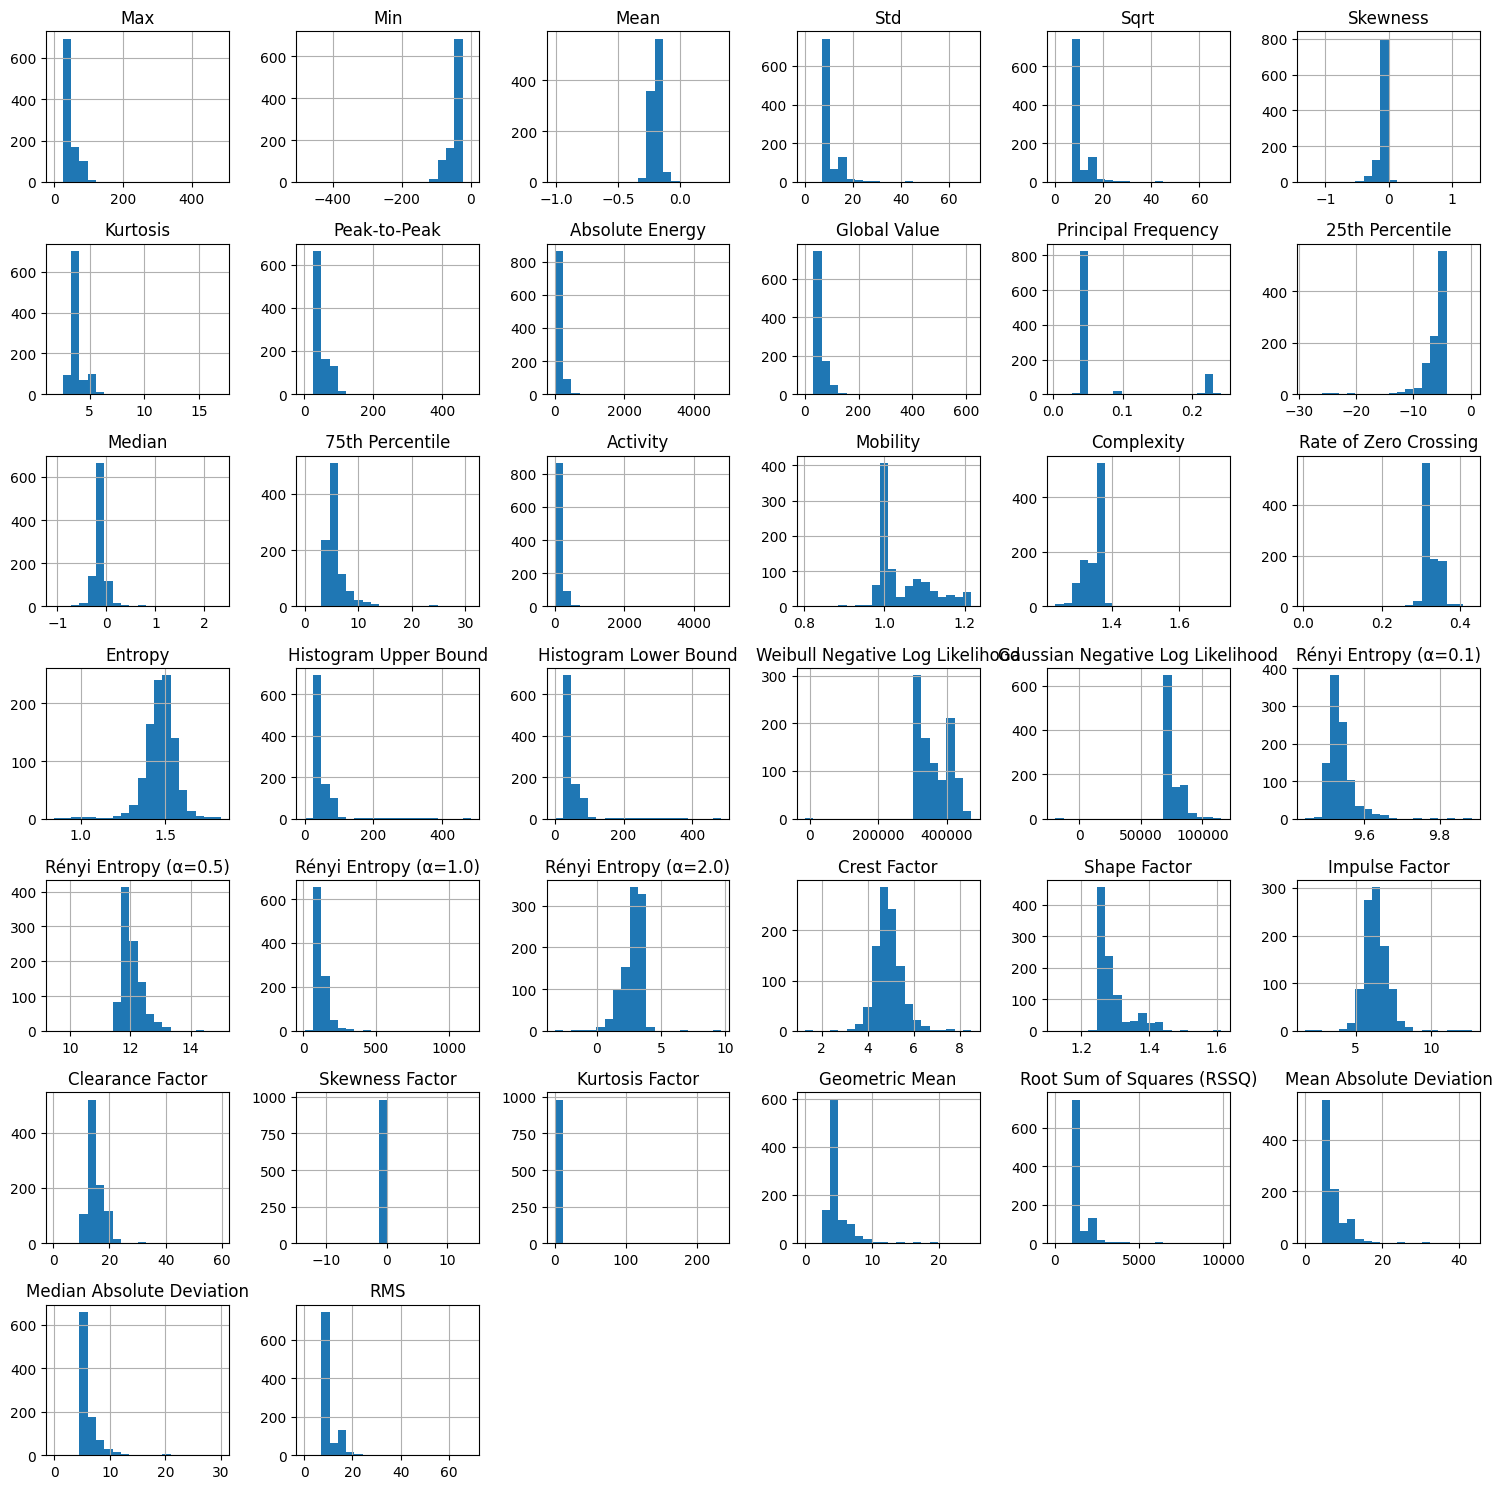

In [ ]:
#histograms
All_new_feature_matrix.hist(figsize=(15, 15), bins=20)
plt.tight_layout()
plt.show()


In [ ]:
'''
# Time-Domain Features
mean_signal = np.mean(vibration_data)
std_signal = np.std(vibration_data)
max_signal = np.max(vibration_data)
min_signal = np.min(vibration_data)
rms_signal = np.sqrt(np.mean(np.square(vibration_data)))
kurtosis_signal = np.mean((vibration_data - mean_signal)**4) / std_signal**4
skewness_signal = np.mean((vibration_data - mean_signal)**3) / std_signal**3
#add
median_signal = np.median(vibration_data)
zero_crossing_rate = np.sum(np.diff(np.sign(vibration_data)) != 0) / len(t)
entropy_signal = entropy(np.abs(vibration_data))
hist_upper_bound = np.max(vibration_data) + ((np.max(vibration_data) - np.min(vibration_data) / (len(t) - 1)) / 2)
hist_lower_bound = np.max(vibration_data) - ((np.max(vibration_data) - np.min(vibration_data) / (len(t) - 1)) / 2)
activity = np.sum(np.abs(np.diff(vibration_data)))
mobility = np.std(np.diff(vibration_data)) / np.std(vibration_data)
complexity = (mobility / activity) * (entropy_signal)
#added
# Frequency-Domain Features
peak_frequency = frequencies_spectrum[np.argmax(np.abs(original_spectrum))]
max_magnitude = np.max(np.abs(original_spectrum))
freq_at_max_magnitude = frequencies_spectrum[np.argmax(np.abs(original_spectrum))]'''

In [ ]:
'''# Printing extracted features
print("Time-Domain Features:")
print("Mean:", mean_signal)
print("Standard Deviation:", std_signal)
print("Maximum:", max_signal)
print("Minimum:", min_signal)
print("RMS:", rms_signal)
print("Kurtosis:", kur
tosis_signal)
print("Skewness:", skewness_signal)
#added
print("Median:", median_signal)
print("Zero Crossing Rate:", zero_crossing_rate)
print("Entropy:", entropy_signal)
print("Histogram Upper Bound T24:", hist_upper_bound)
print("Histogram Lower Bound T25:", hist_lower_bound)
print("Activity:", activity)
print("Mobility:", mobility)
print("Complexity:", complexity)
 #added
print("\nFrequency-Domain Features:")
print("Peak Frequency:", peak_frequency)
print("Maximum Magnitude in Frequency Spectrum:", max_magnitude)
print("Frequency at Maximum Magnitude:", freq_at_max_magnitude)'''

In [ ]:
'''#feature vector
feature_vector = np.array([
    mean_signal,
    median_signal,
    rms_signal,
    min_signal,
    std_signal,
    zero_crossing_rate,
    entropy_signal,
    skewness_signal,
    kurtosis_signal,
    hist_upper_bound,
    hist_lower_bound,
    activity,
    mobility,
    complexity
    # Add Weibull and Normal negative log likelihood features here
])
print("Feature Vector:")
print(feature_vector)'''